In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch_directml
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
from torchvision import transforms
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from piqa import MS_SSIM

In [2]:
# use CUDA processors if available
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch_directml.device()
print(f"Using {device} device")

Using cpu device


In [3]:
def get_img_path(digit, i):
    # get the image path given the digit and the index of the image within the digit
    # eg. get_img_path(4, 12) denotes the 13th image of digit 4
    if digit == 0:
        img_num = 9000
    else:
        img_num = (digit - 1) * 1000
    img_num += (i+1)
    return f'../data/labels/{digit}/image{img_num}.png'


def gather_data(exp_type: str, detect_type: str, feature_name: str, num_features: int):
    # prepare feature data and image paths
    features = None
    image_paths = []
    digits = []
    for digit in range(10):
        fpath = f'../data/features/{exp_type}/{detect_type}/{feature_name}/{feature_name}{digit}.csv'
        data = pd.read_csv(fpath, header=None)

        for i in range(len(data)):
            dig = data[0][i]
            image_paths.append(get_img_path(dig, i))
            digits += [dig]

        data = data.drop(0, axis=1)
        data = data.iloc[:,:num_features]
        if features is None:
            features = data.to_numpy()
        else:
            features = np.append(features, data.to_numpy(), axis=0)

    features = torch.tensor(features.astype(np.float32)).to(device)
    return features, image_paths, digits

# define data transformations
def feature_transform(x: torch.Tensor):
    # standardizes the features of a given data point
    mean = x.mean()
    std = x.std()
    return x.sub(mean).div(std).to(device)


def img_transform(y: str):
    # transforms an image path to a usable tensor
    image = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    convert_tensor = A.Compose([A.ToFloat(max_value=255), ToTensorV2()])
    try:
        thingy = convert_tensor(image=image)['image']
        return thingy.to(device)
    except Exception as e:
        print(e)
        raise Exception(f"cannot load image: {y}")


def digit_transform(y: int):
    return y


# create Datasets and DataLoaders
class ReconstructionData(Dataset):
    def __init__(self, raw_features: torch.Tensor, labels: list, feature_transform, label_transform: None):
        self.features = raw_features
        self.labels = labels
        self.feature_transform = feature_transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        data = self.feature_transform(self.features[idx])
        label = self.label_transform(self.labels[idx])
        return data, label


def prep_data(features, labels, val_size, feature_transform, label_transform, batch_size):
    # create train and validation dataloaders
    train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size=val_size)
    train_data = ReconstructionData(train_features, train_labels, feature_transform, label_transform)
    val_data = ReconstructionData(val_features, val_labels, feature_transform, label_transform)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    return train_dataloader, val_dataloader


class ImgReconstructNN(nn.Module):
    def __init__(self, num_features: int):
        super(ImgReconstructNN, self).__init__()
        self.reconstruct_stack = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.PReLU(),
            nn.Linear(1024, 4096),
            nn.PReLU(),
            nn.Linear(4096, (4*28)*(4*28)),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 4*28, 4*28)),
            nn.Conv2d(1,4,4,padding=2),
            nn.MaxPool2d(2),
            nn.Conv2d(4,1,2,padding=1),
            nn.MaxPool2d(2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.reconstruct_stack(x)
        return logits


class ImgReconstructClassifyNN(nn.Module):
    def __init__(self):
        super(ImgReconstructClassifyNN, self).__init__()
        self.reconstruct_classify_stack = nn.Sequential(
            nn.Linear(300, 2048),
            nn.PReLU(),
            nn.Linear(2048, 2048),
            nn.PReLU(),
            nn.Linear(2048, (8*28)*(8*28)),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 8*28, 8*28)),
            nn.Conv2d(1, 1, 8, padding=4),
            nn.MaxPool2d(2),
            nn.Conv2d(1, 1, 4, padding=2),
            nn.MaxPool2d(2),
            nn.Conv2d(1, 1, 2, padding=1),
            nn.MaxPool2d(2),
            nn.Sigmoid(),
            nn.Conv2d(1, 10, 5),
            nn.MaxPool2d(2),
            nn.PReLU(),
            nn.Conv2d(10, 20, 5),
            nn.MaxPool2d(2),
            nn.PReLU(),
            nn.Linear(320, 50),
            nn.PReLU(),
            nn.Linear(50, 10),
            nn.Softmax(),
        )

    def forward(self, x):
        logits = self.reconstruct_classify_stack(x)
        return logits


# Training loop
def train_loop(dataloader: DataLoader, val_dataloader: DataLoader, model: nn.Module, loss_fn, optimizer, print_loss: bool, train_losses: list, val_losses: list) -> list:
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= num_batches
    train_losses.append(train_loss)
    if print_loss:
        print(f"Avg batch loss: {train_loss:>8f}")

    model.eval()
    with torch.no_grad():
        test_loss = 0
        for (X, y) in val_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
        train_loss /= num_batches
        val_losses.append(test_loss)
    model.train()

    return train_losses, val_losses


def reconstruct_test_loop(dataloader, model, loss_fn):
    model.eval()
    print("Running Test Loop")
    num_batches = len(dataloader)
    test_loss = 0
    test_psnr = 0
    test_ssim = 0
    psnr = PeakSignalNoiseRatio().to(device)
    ssim = StructuralSimilarityIndexMeasure().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            print(f"batch: {batch+1}")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_ssim += ssim(pred, y).item()
            test_psnr += psnr(pred, y).item()

            # display 1 original and predicted image from each batch
            transform = transforms.ToPILImage()
            orig_data = y[0]
            orig_img = transform(orig_data)
            pred_data = pred[0]
            pred_img = transform(pred_data)
            diff_data = torch.abs(pred_data - orig_data)
            diff_img = transform(diff_data)
            print("original:")
            display(orig_img)
            print("predicted:")
            display(pred_img)
            print("difference:")
            display(diff_img)
            print()

    test_loss /= num_batches
    test_psnr /= num_batches
    test_ssim /= num_batches
    print(f"Avg batch loss: {test_loss:>8f}")
    print(f"Avg batch PSNR: {test_psnr:>8f}")
    print(f"Avg batch SSIM: {test_ssim:>8f}")
    return model, test_loss, test_psnr, test_ssim


def reconstruct_test_loop(dataloader, model, loss_fn):
    model.eval()
    print("Running Test Loop")
    num_batches = len(dataloader)
    test_loss = 0
    test_psnr = 0
    test_ssim = 0
    psnr = PeakSignalNoiseRatio().to(device)
    ssim = StructuralSimilarityIndexMeasure().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            print(f"batch: {batch+1}")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_ssim += ssim(pred, y).item()
            test_psnr += psnr(pred, y).item()

            # display 1 original and predicted image from each batch
            transform = transforms.ToPILImage()
            orig_data = y[0]
            orig_img = transform(orig_data)
            pred_data = pred[0]
            pred_img = transform(pred_data)
            diff_data = torch.abs(pred_data - orig_data)
            diff_img = transform(diff_data)
            print("original:")
            display(orig_img)
            print("predicted:")
            display(pred_img)
            print("difference:")
            display(diff_img)
            print()

    test_loss /= num_batches
    test_psnr /= num_batches
    test_ssim /= num_batches
    print(f"Avg batch loss: {test_loss:>8f}")
    print(f"Avg batch PSNR: {test_psnr:>8f}")
    print(f"Avg batch SSIM: {test_ssim:>8f}")
    return model, test_loss, test_psnr, test_ssim


def reconstruct_test_loop(dataloader, model, loss_fn):
    model.eval()
    print("Running Test Loop")
    num_batches = len(dataloader)
    test_loss = 0
    test_psnr = 0
    test_ssim = 0
    psnr = PeakSignalNoiseRatio().to(device)
    ssim = StructuralSimilarityIndexMeasure().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            print(f"batch: {batch+1}")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_ssim += ssim(pred, y).item()
            test_psnr += psnr(pred, y).item()

            # display 1 original and predicted image from each batch
            transform = transforms.ToPILImage()
            orig_data = y[0]
            orig_img = transform(orig_data)
            pred_data = pred[0]
            pred_img = transform(pred_data)
            diff_data = torch.abs(pred_data - orig_data)
            diff_img = transform(diff_data)
            print("original:")
            display(orig_img)
            print("predicted:")
            display(pred_img)
            print("difference:")
            display(diff_img)
            print()

    test_loss /= num_batches
    test_psnr /= num_batches
    test_ssim /= num_batches
    print(f"Avg batch loss: {test_loss:>8f}")
    print(f"Avg batch PSNR: {test_psnr:>8f}")
    print(f"Avg batch SSIM: {test_ssim:>8f}")
    return model, test_loss, test_psnr, test_ssim


def train_model(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_losses = []
    val_losses = []
    for t in range(epochs):
        print_loss = False
        if (t % 8 == 7) or (t==0):
            print_loss = True
            print("-------------------------------")
            print(f"Epoch {t+1}")
        train_losses, val_losses = train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, print_loss, train_losses, val_losses)
    print("Done!")
    return train_losses, val_losses


def plot_loss(losses: list, val: bool) -> None:
    losses = np.array(torch.tensor(losses).cpu())
    plt.plot(losses, color='red')
    plt.ylabel('Average Batch Loss') #set the label for y axis
    plt.xlabel('Epoch') #set the label for x-axis
    if val:
        plt.title("Validation Loss over Epochs") #set the title of the graph
    else:
        plt.title("Training Loss over Epochs") #set the title of the graph
    plt.show() #display the graph


l1 = nn.L1Loss()
class L1_SSIM_loss(MS_SSIM):
    def forward(self, x, y):
        return (0.5 * (1. - super().forward(x, y))) + (0.5 * l1.forward(x, y))


def reconstruct(exp_type, detect_type, feature_name, batch_size, val_size, epochs, loss_fn, learning_rate, num_features):
    print(f"\nTRAINING RECONSRTUCTION MODEL FOR: {feature_name}\n")
    print("PART 1")
    features, image_paths, digits = gather_data(exp_type, detect_type, feature_name, num_features)
    print("PART 2")
    train_dataloader, val_dataloader = prep_data(features, image_paths, val_size, feature_transform, img_transform, batch_size)
    print("PART 3")
    model = ImgReconstructNN(num_features).to(device)
    print(model)
    print("PART 4")
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    print("PART 5")
    train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs)
    print("PART 6")
    plot_loss(train_losses, False)
    plot_loss(val_losses, True)
    print("PART 7")
    model, val_loss, val_psnr, val_ssim = reconstruct_test_loop(val_dataloader, model, loss_fn)
    saved_losses_loc = f'../data/features/{exp_type}/{detect_type}/{feature_name}/{num_features}_reconstruct_losses.pt'
    torch.save((train_losses, val_loss), saved_losses_loc)
    return val_loss, val_psnr, val_ssim



TRAINING RECONSRTUCTION MODEL FOR: annd40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.511102
-------------------------------
Epoch 8
Avg batch loss: 0.205277
-------------------------------
Epoch 16
Avg batch 

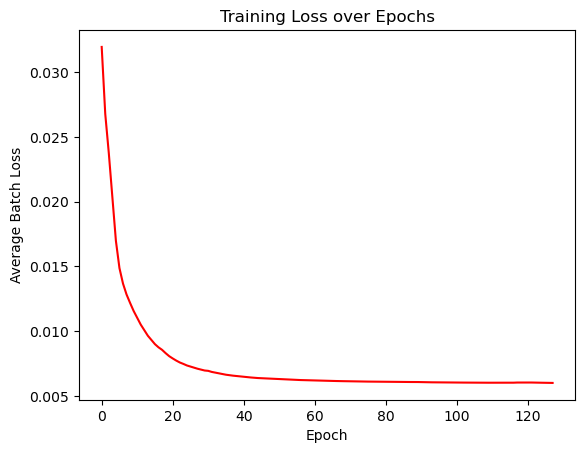

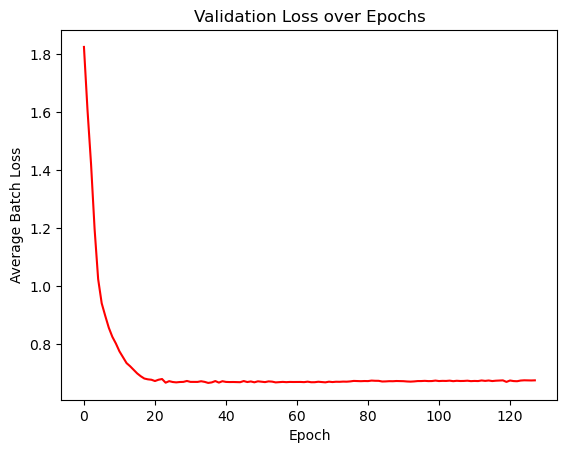

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.168557
Avg batch PSNR: 13.519978
Avg batch SSIM: 0.402994

TRAINING RECONSRTUCTION MODEL FOR: 0p5tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.534492
-------------------------------
Epoch

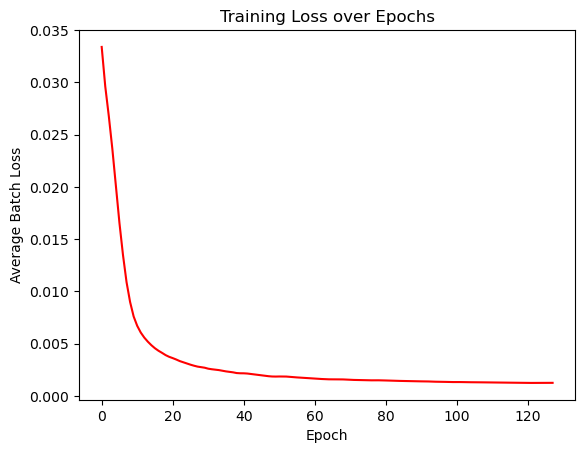

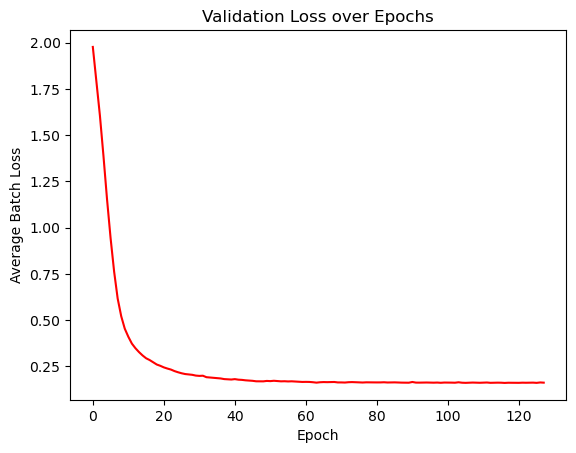

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.040588
Avg batch PSNR: 19.668686
Avg batch SSIM: 0.867650

TRAINING RECONSRTUCTION MODEL FOR: 100tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.495808
-------------------------------
Epoch

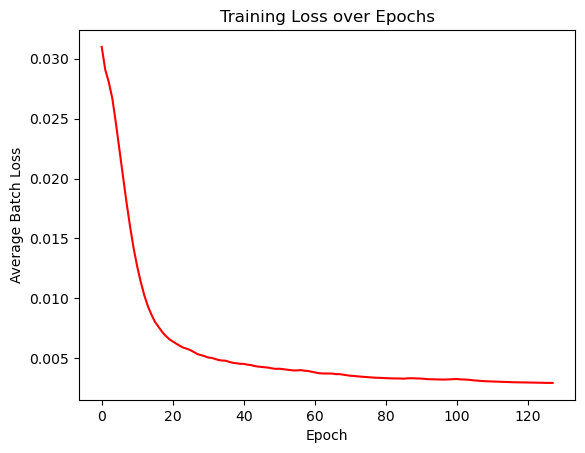

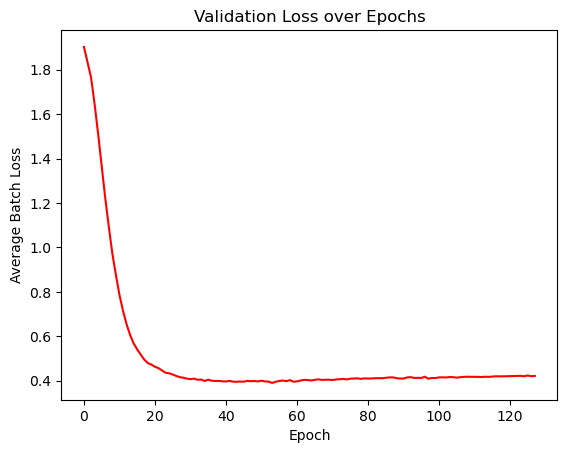

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.105395
Avg batch PSNR: 15.308143
Avg batch SSIM: 0.636506

TRAINING RECONSRTUCTION MODEL FOR: 10tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.482400
-------------------------------
Epoch 

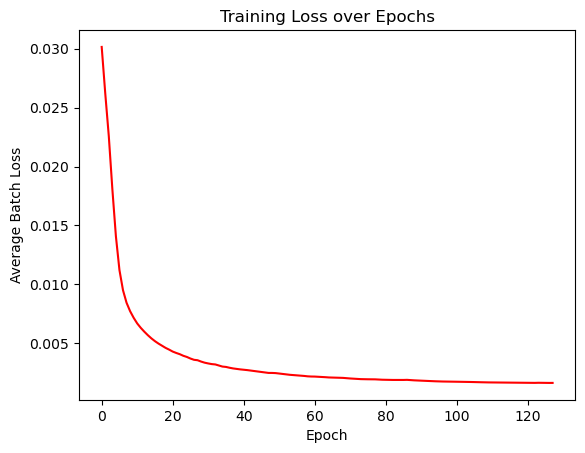

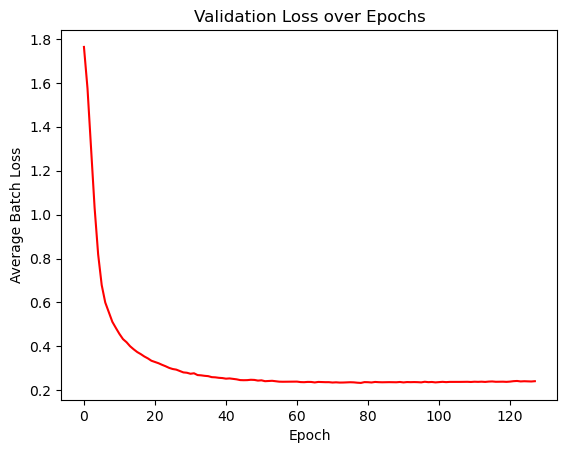

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.060436
Avg batch PSNR: 18.020347
Avg batch SSIM: 0.797236

TRAINING RECONSRTUCTION MODEL FOR: 1tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.498820
-------------------------------
Epoch 8

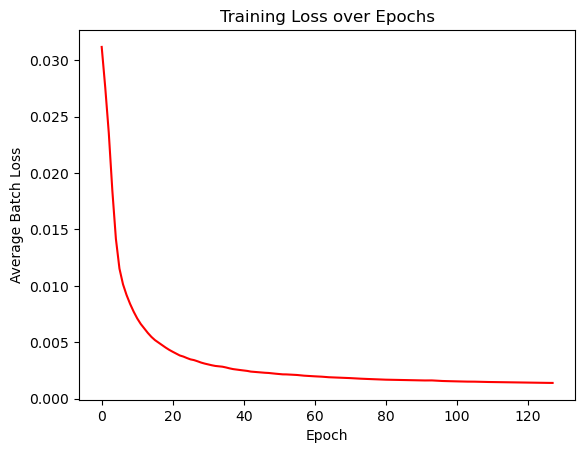

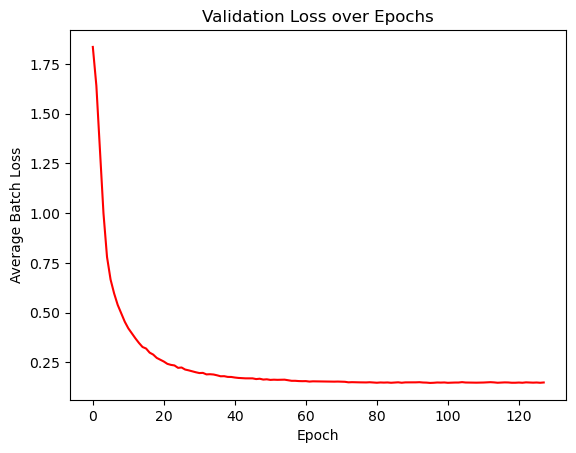

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.037240
Avg batch PSNR: 20.355040
Avg batch SSIM: 0.871351

TRAINING RECONSRTUCTION MODEL FOR: 200tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.479662
-------------------------------
Epoch

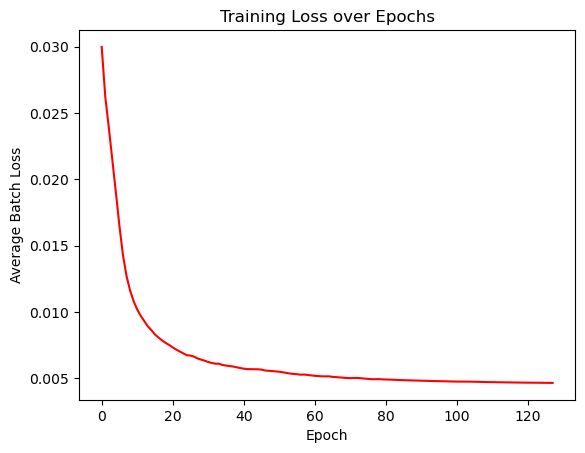

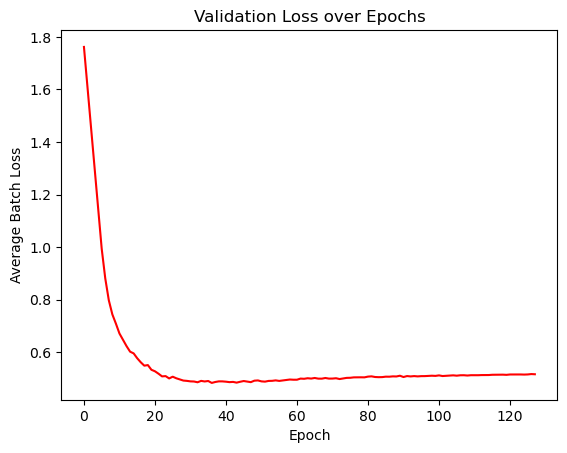

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.129076
Avg batch PSNR: 14.592075
Avg batch SSIM: 0.546278

TRAINING RECONSRTUCTION MODEL FOR: 20tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.493354
-------------------------------
Epoch 

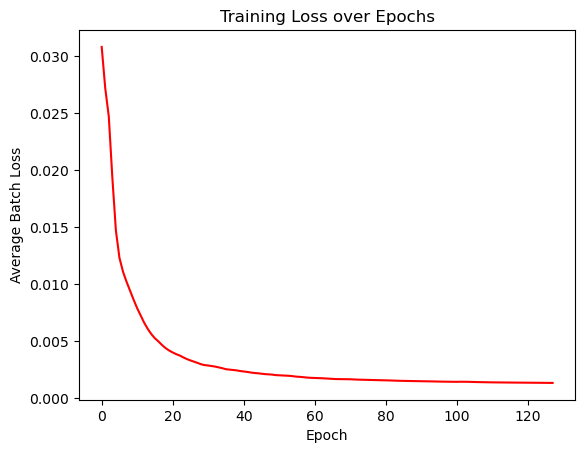

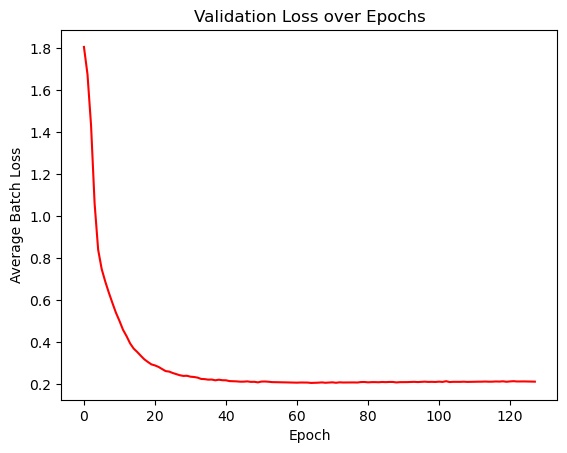

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.053121
Avg batch PSNR: 18.721276
Avg batch SSIM: 0.825233

TRAINING RECONSRTUCTION MODEL FOR: 2tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.480036
-------------------------------
Epoch 8

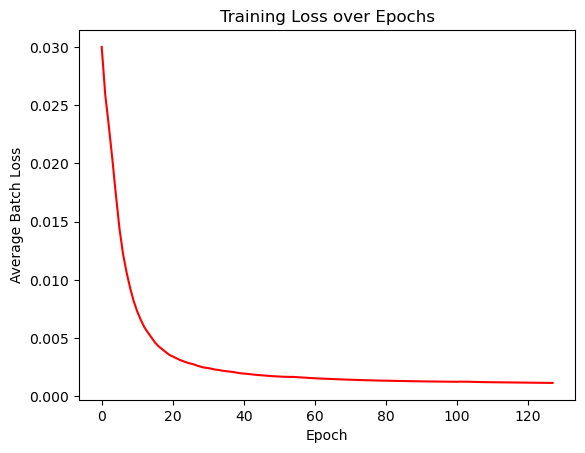

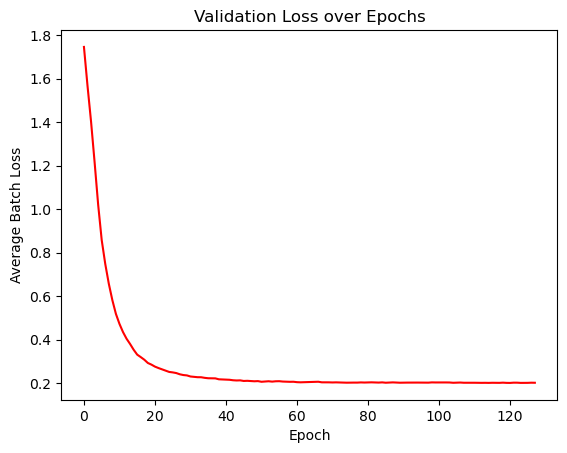

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.050495
Avg batch PSNR: 18.794929
Avg batch SSIM: 0.832634

TRAINING RECONSRTUCTION MODEL FOR: 50tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.510157
-------------------------------
Epoch 

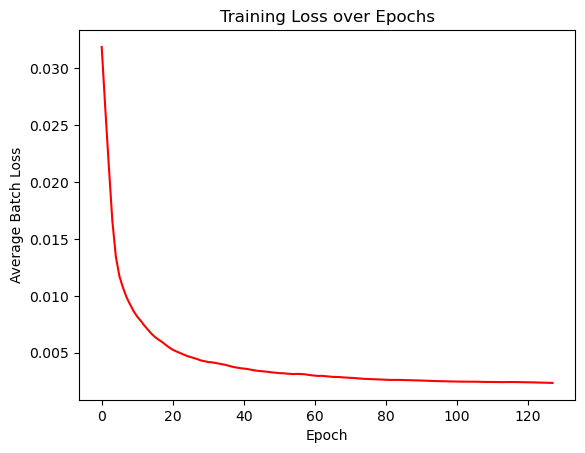

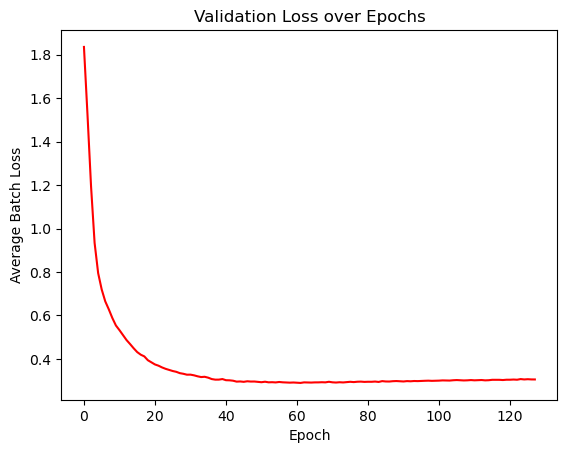

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.076260
Avg batch PSNR: 16.912619
Avg batch SSIM: 0.742212

TRAINING RECONSRTUCTION MODEL FOR: 5tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.484622
-------------------------------
Epoch 8

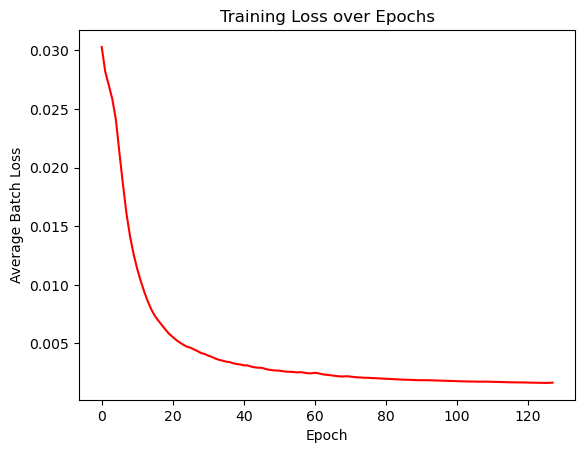

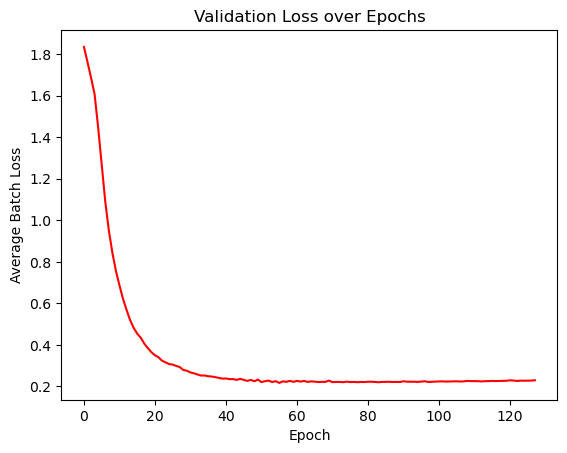

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.057399
Avg batch PSNR: 18.074901
Avg batch SSIM: 0.804871

TRAINING RECONSRTUCTION MODEL FOR: nnfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.489010
-------------------------------
Epoch 8

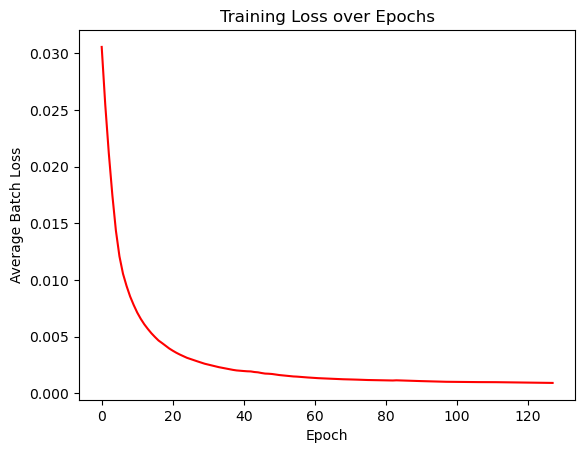

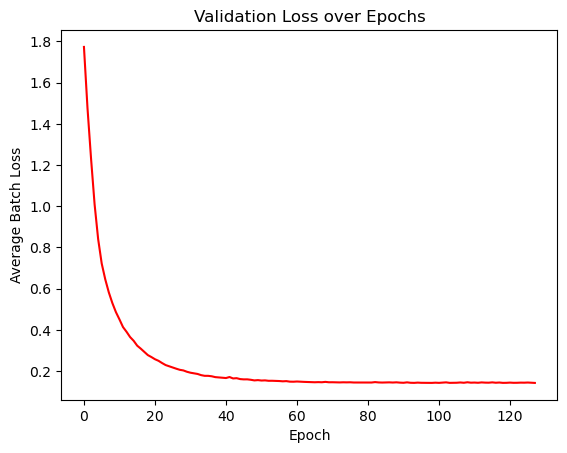

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.035568
Avg batch PSNR: 20.556142
Avg batch SSIM: 0.882517

TRAINING RECONSRTUCTION MODEL FOR: 100n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.471172
-------------------------------
Epoch 8

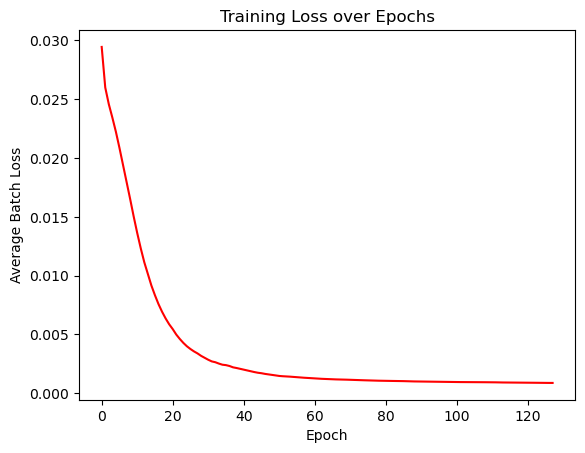

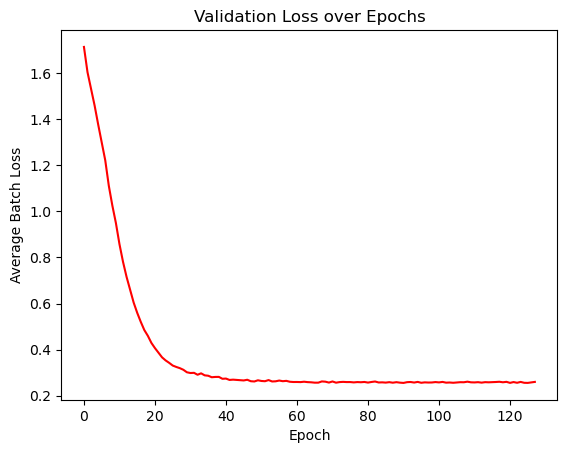

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.064908
Avg batch PSNR: 17.933073
Avg batch SSIM: 0.766171

TRAINING RECONSRTUCTION MODEL FOR: 37n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.469819
-------------------------------
Epoch 8


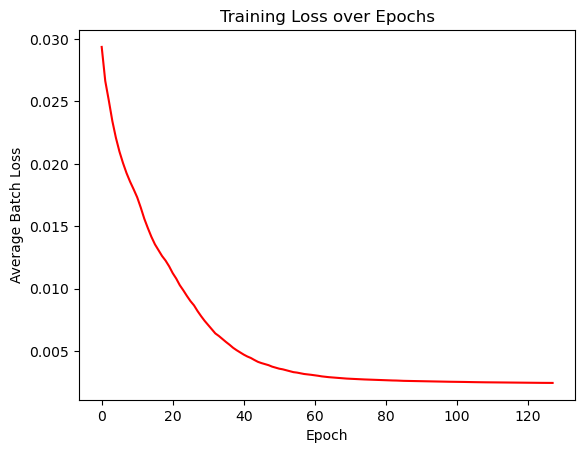

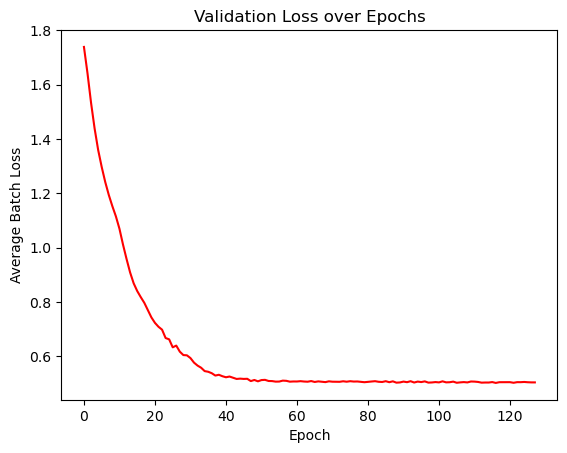

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.125953
Avg batch PSNR: 14.568860
Avg batch SSIM: 0.531727

TRAINING RECONSRTUCTION MODEL FOR: 50n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.487593
-------------------------------
Epoch 8


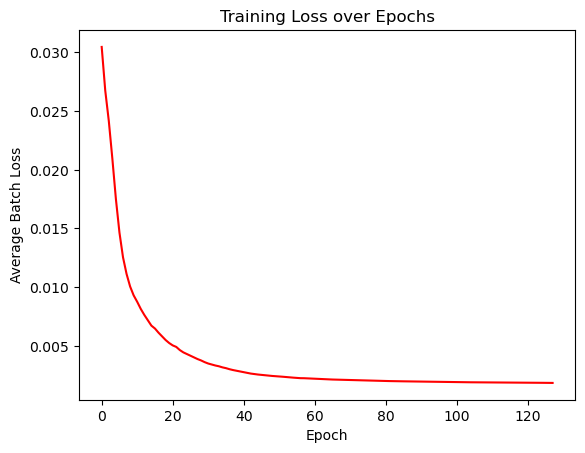

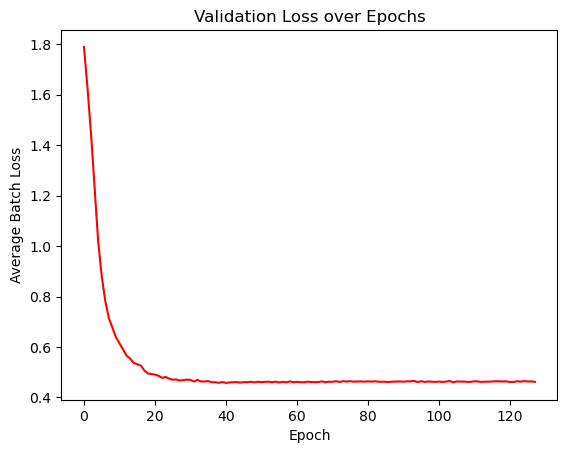

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.115398
Avg batch PSNR: 15.187594
Avg batch SSIM: 0.578023

TRAINING RECONSRTUCTION MODEL FOR: 62n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.504873
-------------------------------
Epoch 8


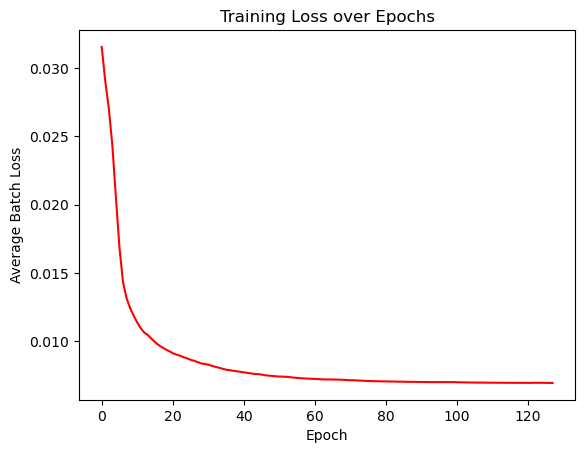

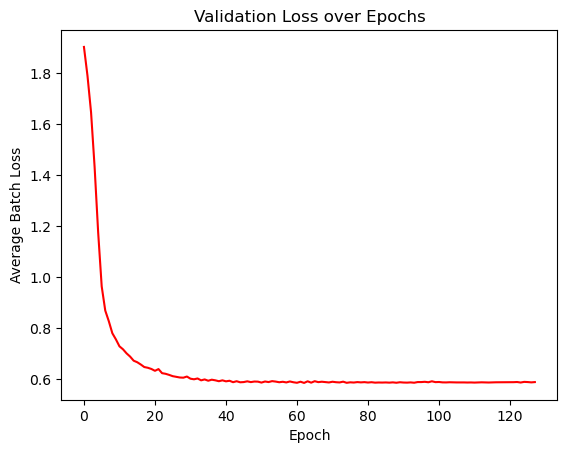

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.147079
Avg batch PSNR: 14.265696
Avg batch SSIM: 0.456435

TRAINING RECONSRTUCTION MODEL FOR: 75n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.516308
-------------------------------
Epoch 8


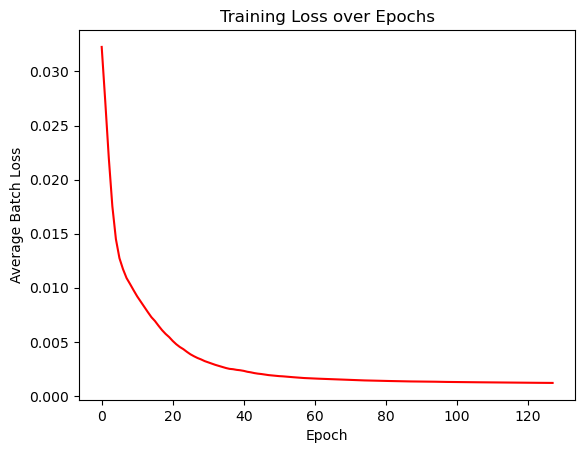

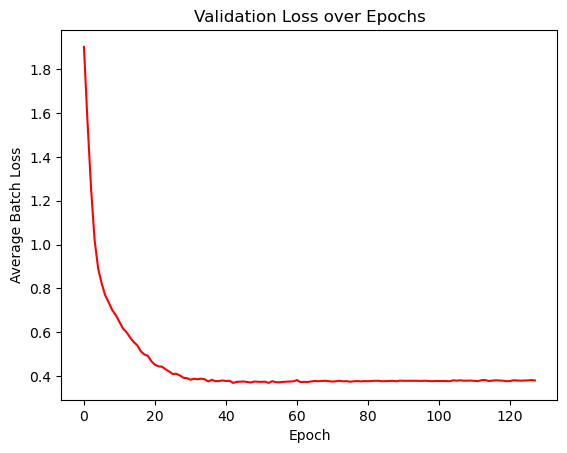

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.094915
Avg batch PSNR: 16.031144
Avg batch SSIM: 0.653204

TRAINING RECONSRTUCTION MODEL FOR: 87p5n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.462008
-------------------------------
Epoch 

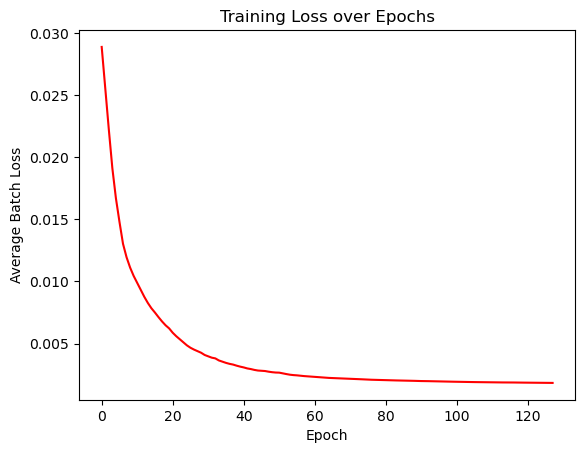

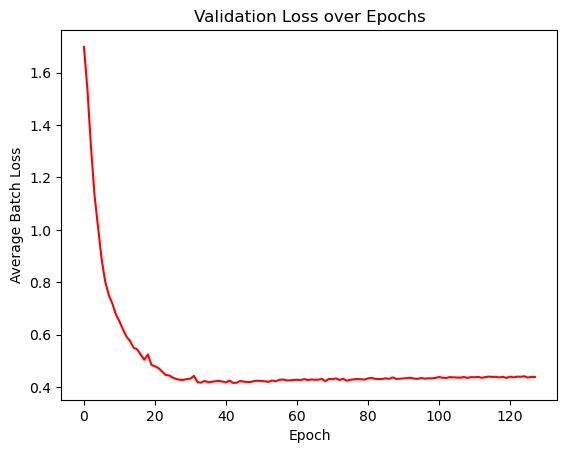

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.109668
Avg batch PSNR: 15.338152
Avg batch SSIM: 0.612510

TRAINING RECONSRTUCTION MODEL FOR: a25n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.486919
-------------------------------
Epoch 8

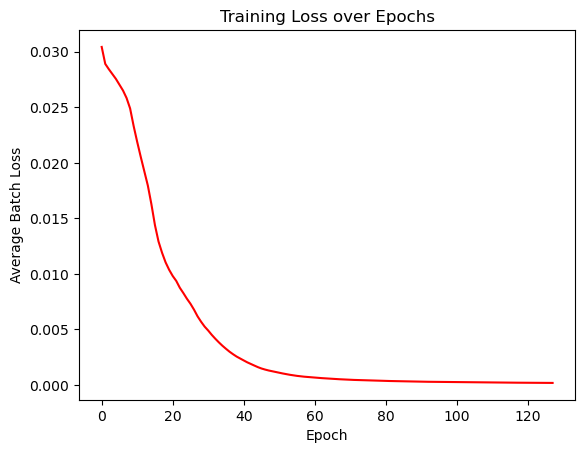

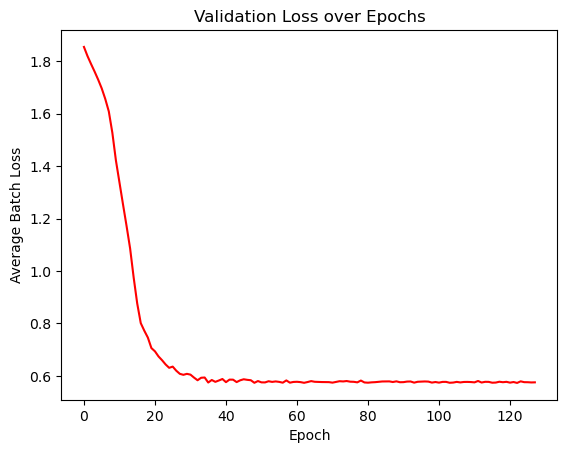

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.143840
Avg batch PSNR: 14.364295
Avg batch SSIM: 0.472603

TRAINING RECONSRTUCTION MODEL FOR: 10fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.476255
-------------------------------
Epoch 8

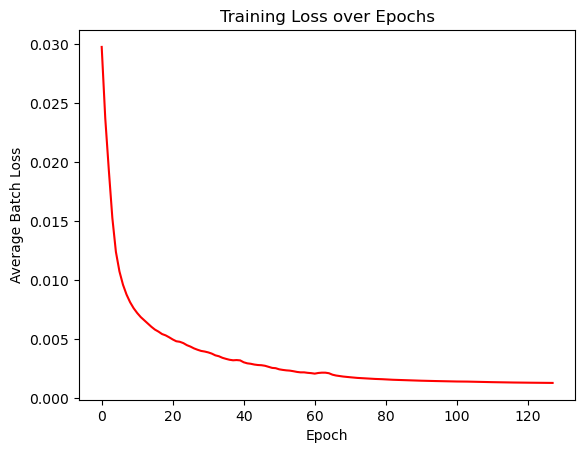

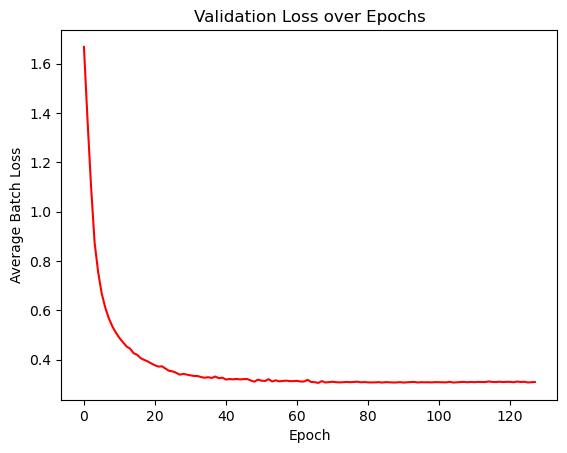

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.077464
Avg batch PSNR: 17.021493
Avg batch SSIM: 0.738726

TRAINING RECONSRTUCTION MODEL FOR: 3fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.528039
-------------------------------
Epoch 8


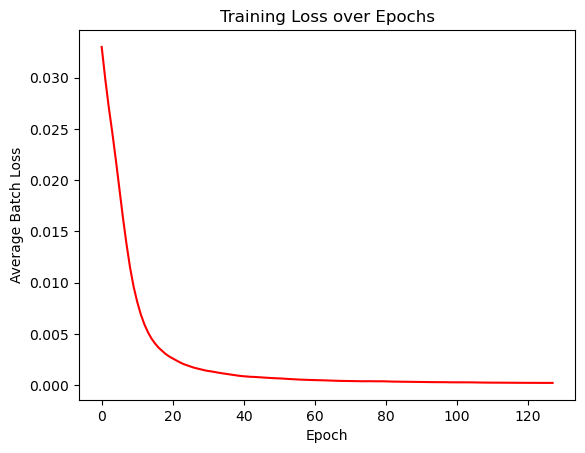

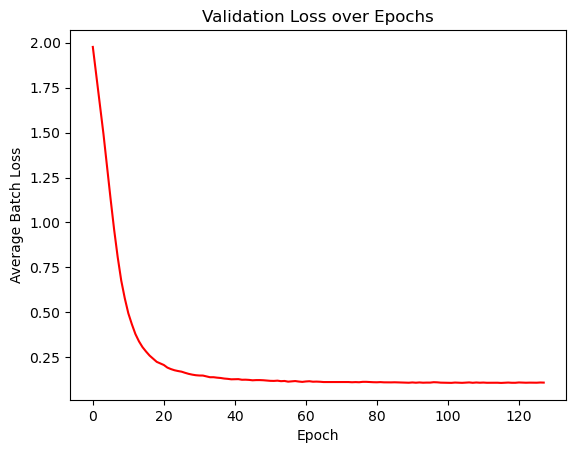

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.027250
Avg batch PSNR: 22.051960
Avg batch SSIM: 0.907100

TRAINING RECONSRTUCTION MODEL FOR: 5fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.495102
-------------------------------
Epoch 8


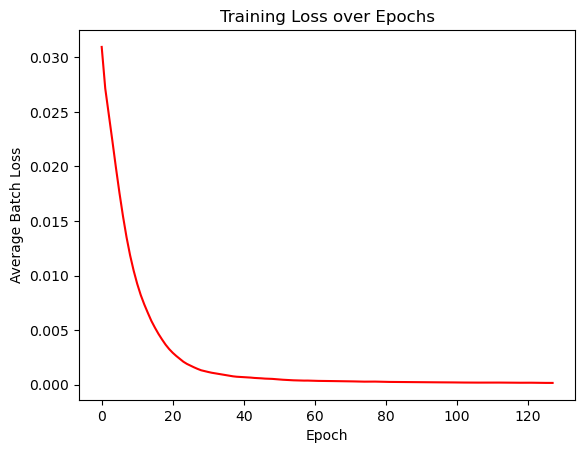

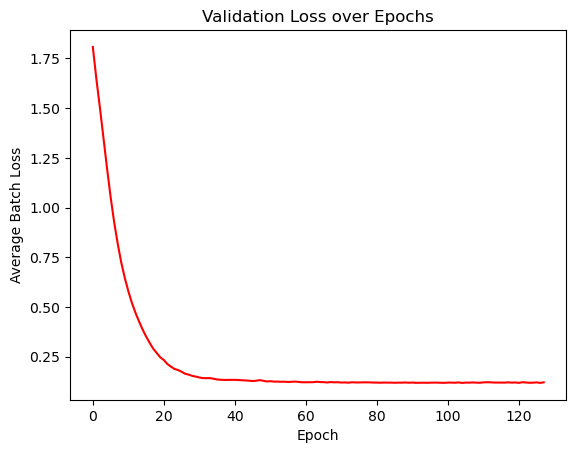

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.030391
Avg batch PSNR: 21.599807
Avg batch SSIM: 0.902250

TRAINING RECONSRTUCTION MODEL FOR: 6fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.488266
-------------------------------
Epoch 8


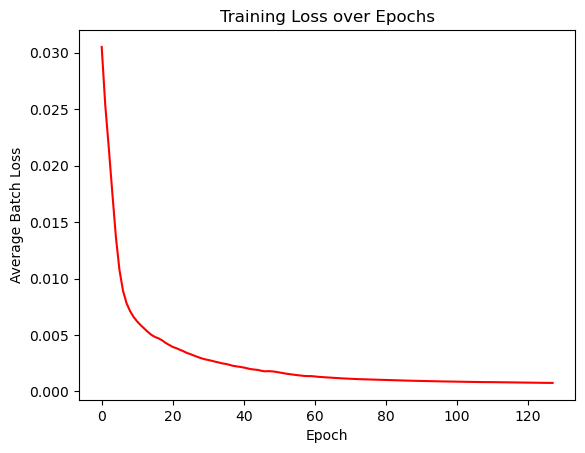

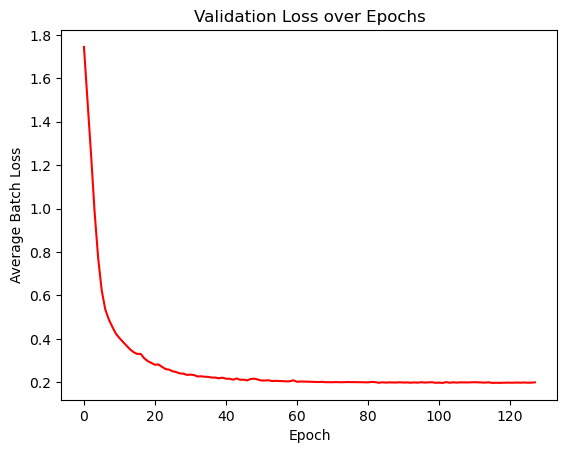

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.049974
Avg batch PSNR: 19.160690
Avg batch SSIM: 0.823821

TRAINING RECONSRTUCTION MODEL FOR: 7a5fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.520711
-------------------------------
Epoch 

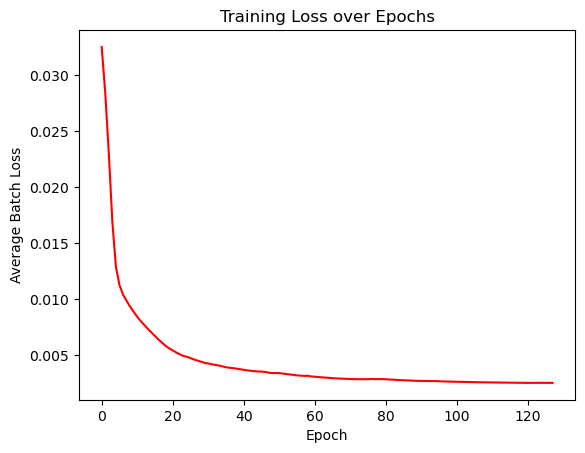

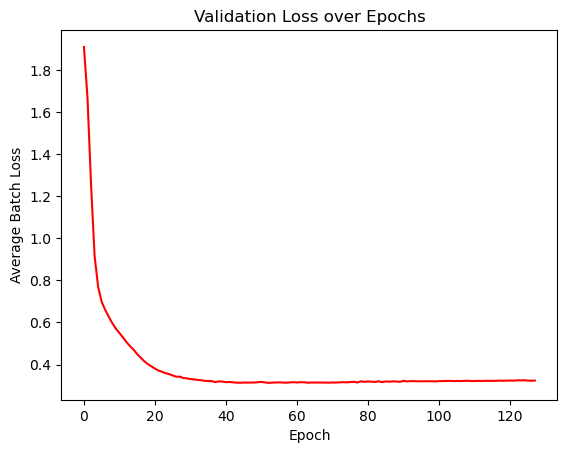

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.080954
Avg batch PSNR: 16.678072
Avg batch SSIM: 0.725222

TRAINING RECONSRTUCTION MODEL FOR: aa15fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.489531
-------------------------------
Epoch

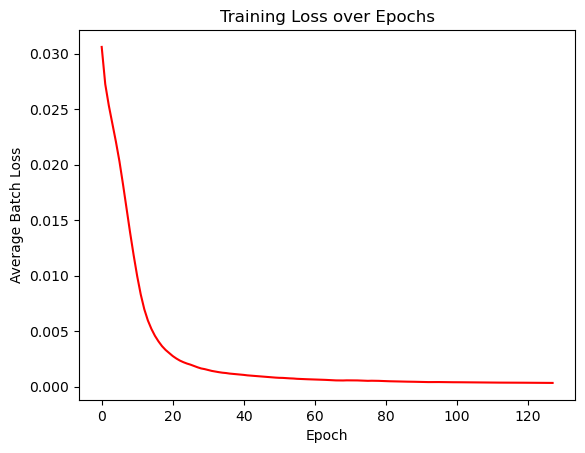

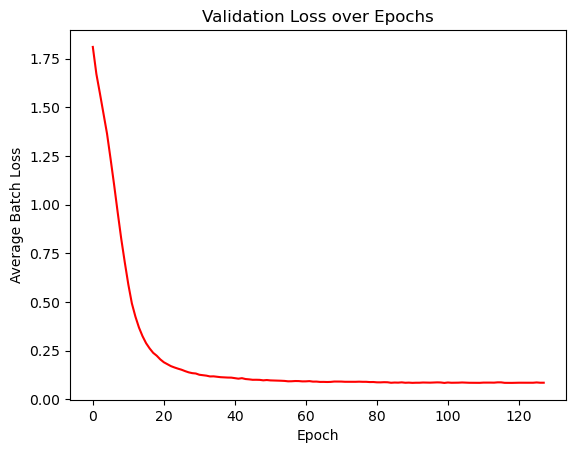

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.021483
Avg batch PSNR: 23.230134
Avg batch SSIM: 0.929841

TRAINING RECONSRTUCTION MODEL FOR: aa20fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.503322
-------------------------------
Epoch

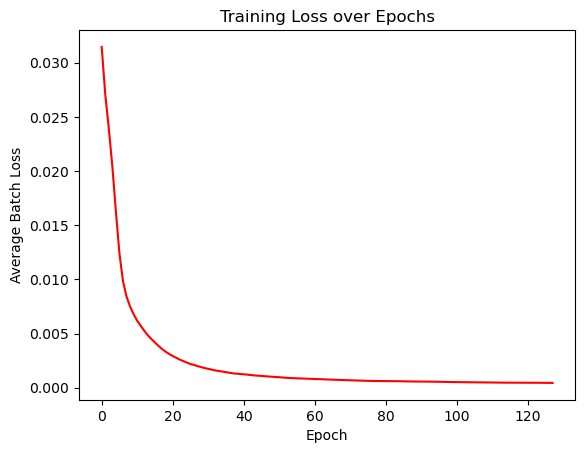

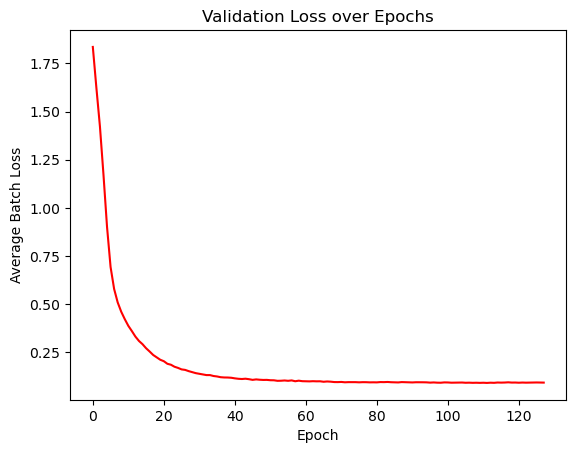

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.023285
Avg batch PSNR: 23.112799
Avg batch SSIM: 0.929451

TRAINING RECONSRTUCTION MODEL FOR: aa25fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.514151
-------------------------------
Epoch

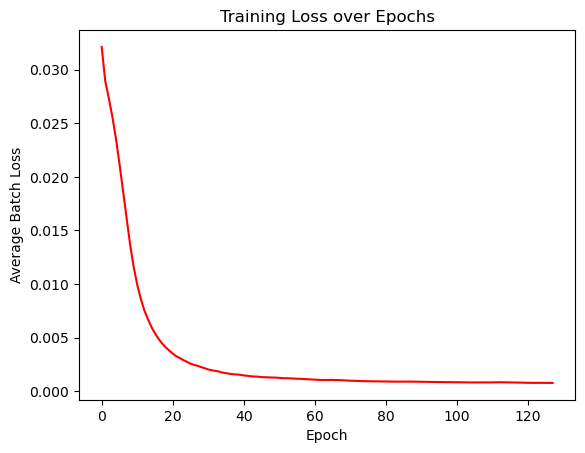

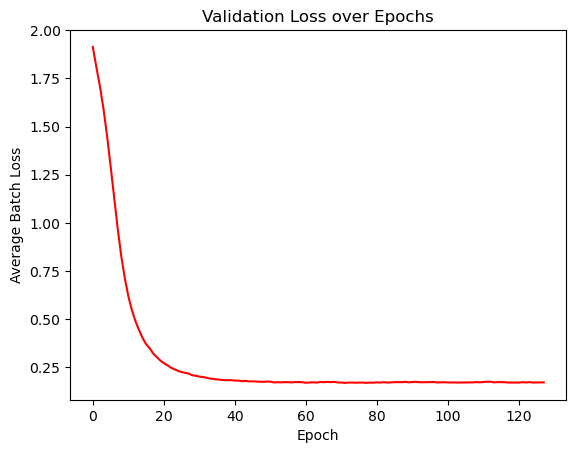

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.042914
Avg batch PSNR: 19.653054
Avg batch SSIM: 0.867192

TRAINING RECONSRTUCTION MODEL FOR: aa30fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.509877
-------------------------------
Epoch

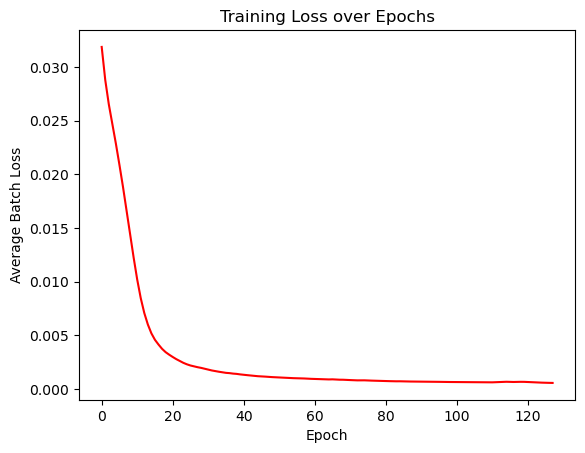

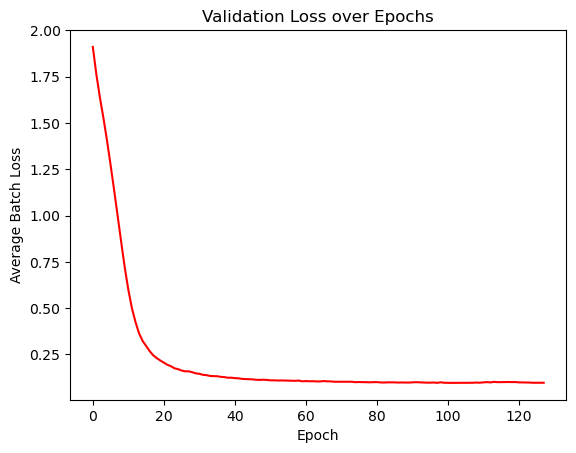

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.024214
Avg batch PSNR: 22.623985
Avg batch SSIM: 0.921205

TRAINING RECONSRTUCTION MODEL FOR: aa35fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.550951
-------------------------------
Epoch

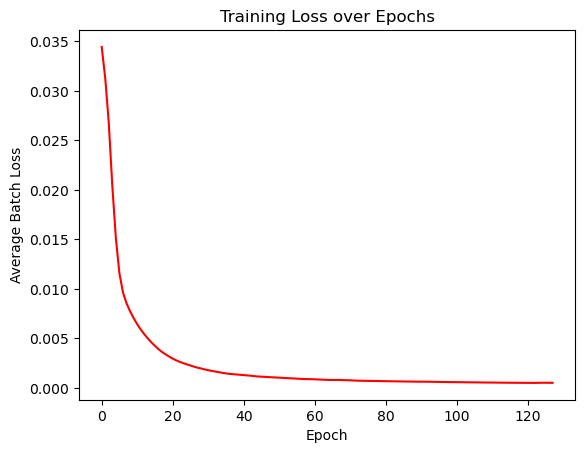

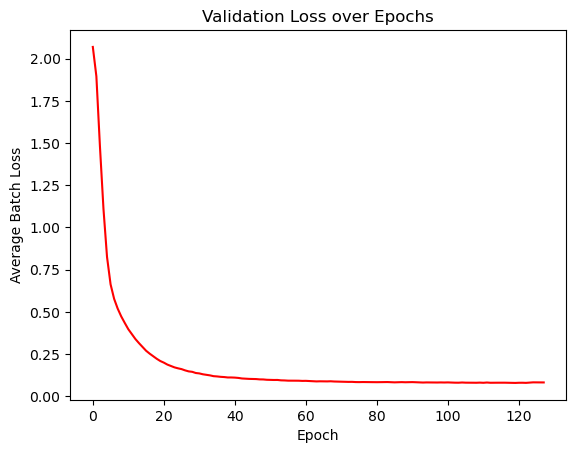

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.020466
Avg batch PSNR: 23.614154
Avg batch SSIM: 0.930981

TRAINING RECONSRTUCTION MODEL FOR: aa40fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.490835
-------------------------------
Epoch

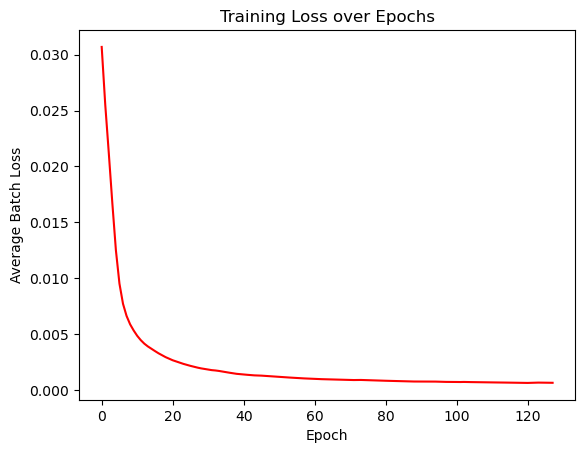

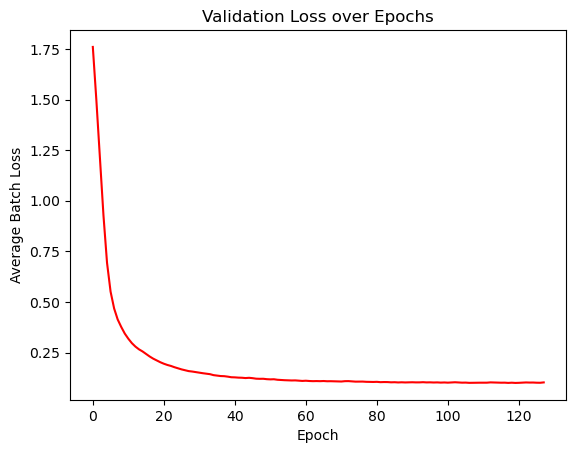

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.025669
Avg batch PSNR: 22.294837
Avg batch SSIM: 0.917394

TRAINING RECONSRTUCTION MODEL FOR: aa5fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.527662
-------------------------------
Epoch 

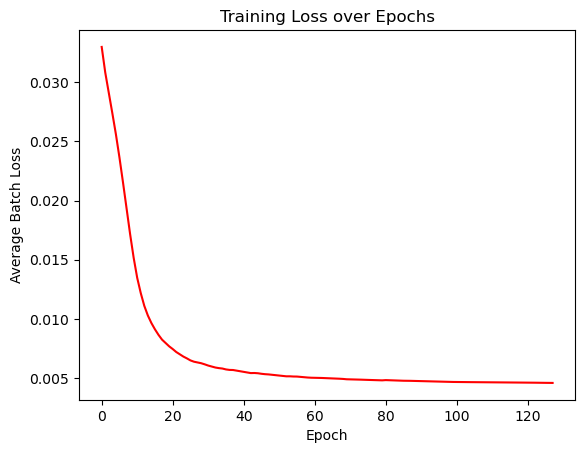

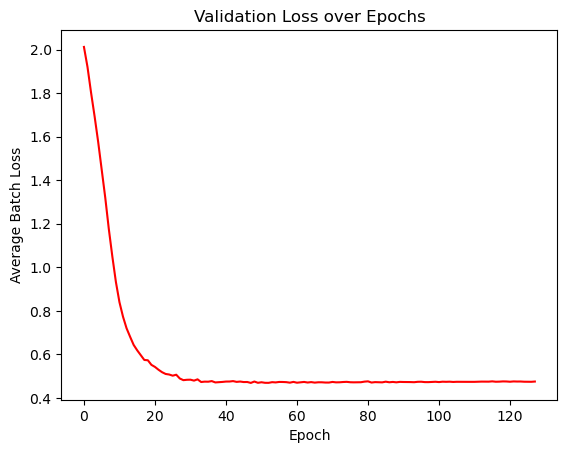

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.118772
Avg batch PSNR: 14.892324
Avg batch SSIM: 0.591538

TRAINING RECONSRTUCTION MODEL FOR: aa6fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.479330
-------------------------------
Epoch 

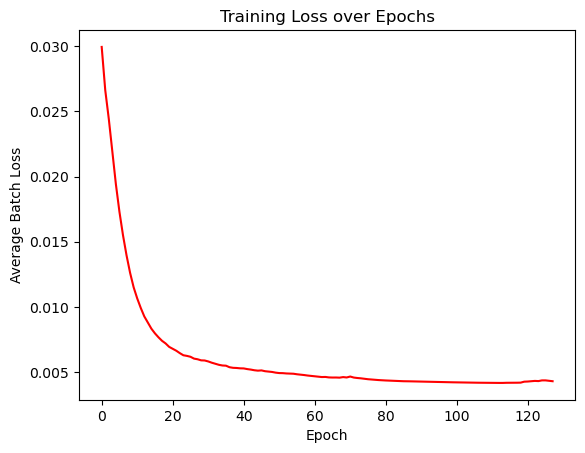

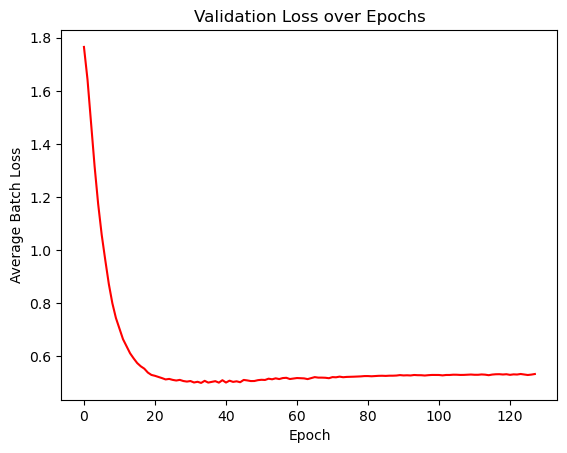

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.133257
Avg batch PSNR: 14.388148
Avg batch SSIM: 0.531408


In [4]:
# hyper parameters
batch_size = 50
val_size = 0.2
epochs = 128
learning_rate = 1e-3
loss_fn = L1_SSIM_loss(window_size=2, n_channels=1).to(device)

num_features = 300

###############################################################################
# IMAGE RECONSTRUCTION
###############################################################################

# VARIED NOISE LEVELS
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/ASE_noise/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/ASE_noise/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = f'../data/features/ASE_noise/{num_features}_reconstruction_results.csv'
results.to_csv(filename, index=False)


# VARIED INTEGRATION TIMES
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/integration_time/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/integration_time/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = f'../data/features/integration_time/{num_features}_reconstruction_results.csv'
results.to_csv(filename, index=False)


TRAINING RECONSRTUCTION MODEL FOR: annd40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.528881
-------------------------------
Epoch 8
Avg batch loss: 0.213303
-------------------------------
Epoch 16
Avg batch 

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.164526
Avg batch PSNR: 13.642226
Avg batch SSIM: 0.414901

TRAINING RECONSRTUCTION MODEL FOR: 0p5tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.479692
-------------------------------
Epoch

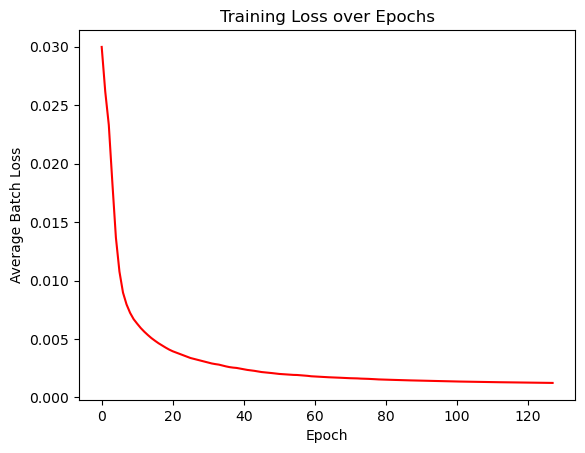

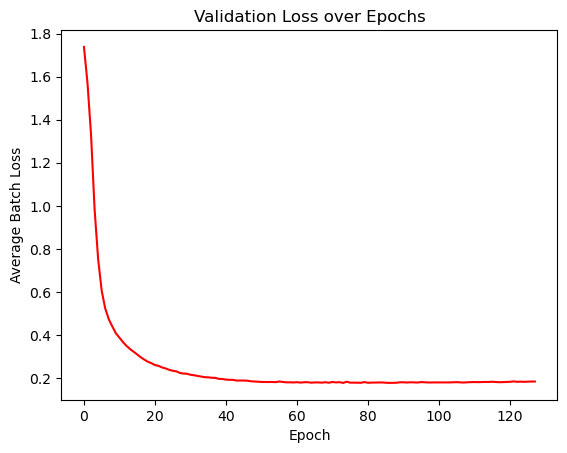

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.045994
Avg batch PSNR: 19.369302
Avg batch SSIM: 0.845759

TRAINING RECONSRTUCTION MODEL FOR: 100tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.523191
-------------------------------
Epoch

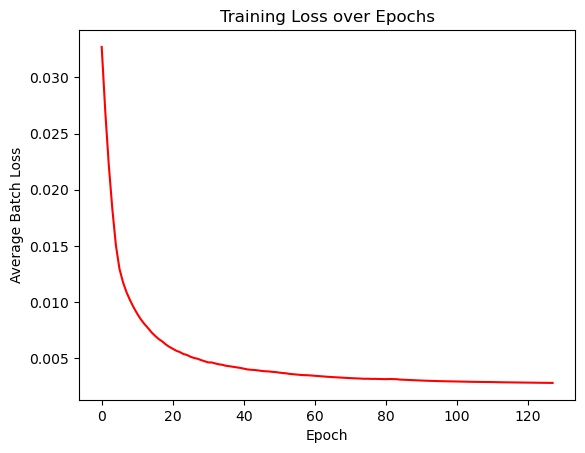

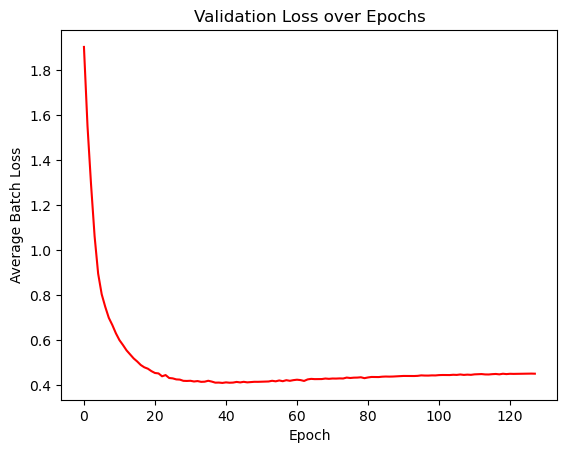

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.113059
Avg batch PSNR: 15.191260
Avg batch SSIM: 0.621657

TRAINING RECONSRTUCTION MODEL FOR: 10tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.495400
-------------------------------
Epoch 

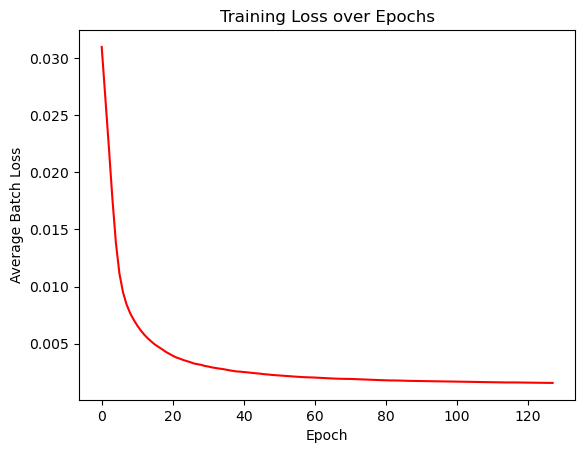

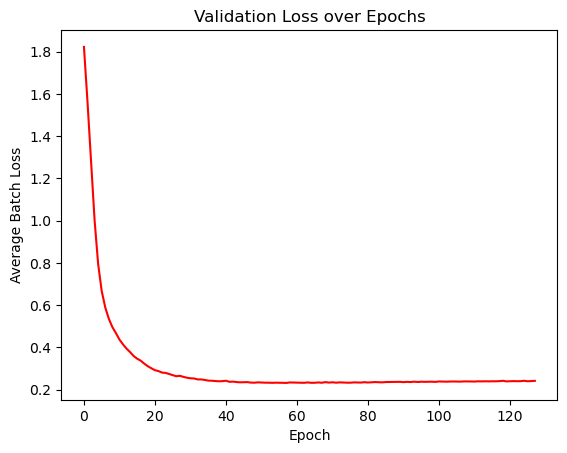

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.060377
Avg batch PSNR: 17.870544
Avg batch SSIM: 0.795804

TRAINING RECONSRTUCTION MODEL FOR: 1tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.511915
-------------------------------
Epoch 8

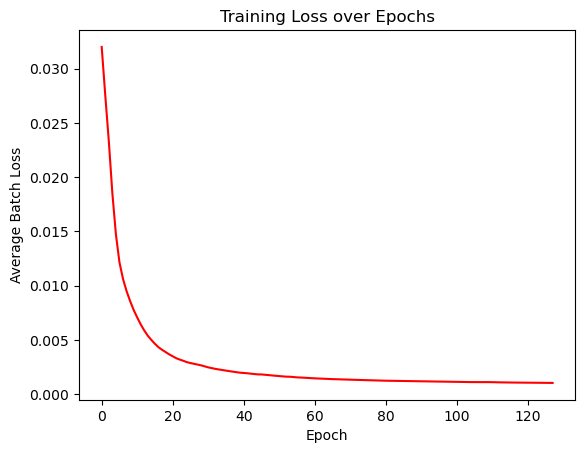

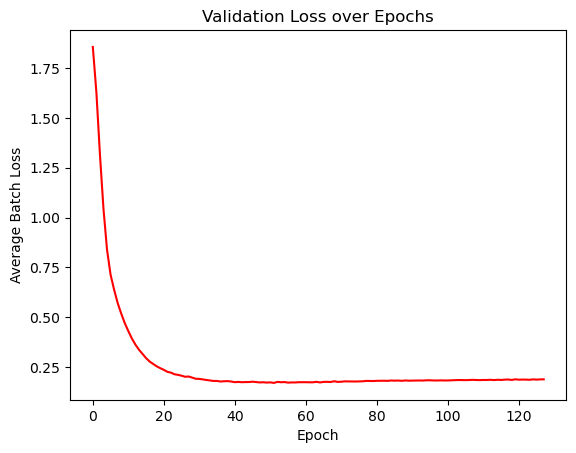

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.046772
Avg batch PSNR: 19.403743
Avg batch SSIM: 0.842431

TRAINING RECONSRTUCTION MODEL FOR: 200tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.404424
-------------------------------
Epoch

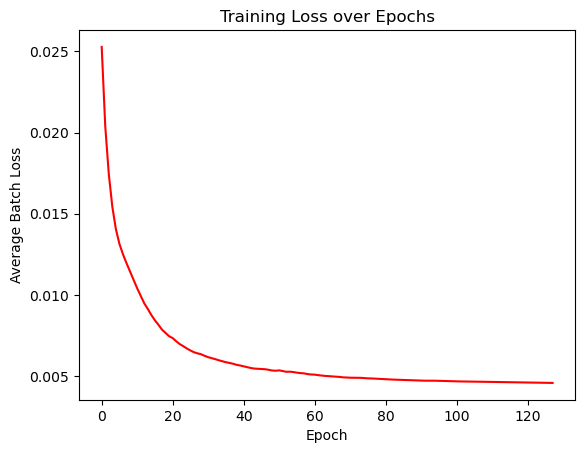

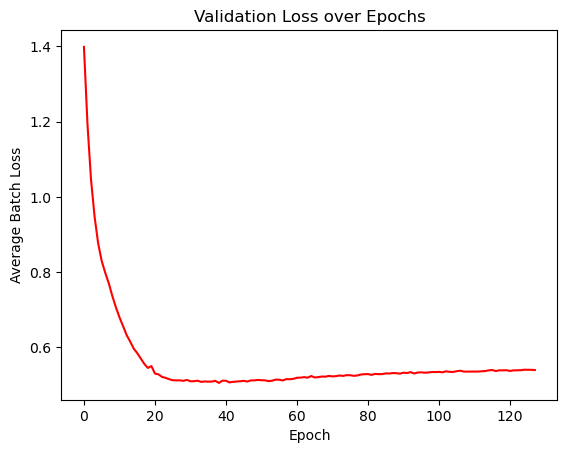

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.134901
Avg batch PSNR: 14.356778
Avg batch SSIM: 0.515768

TRAINING RECONSRTUCTION MODEL FOR: 20tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.492565
-------------------------------
Epoch 

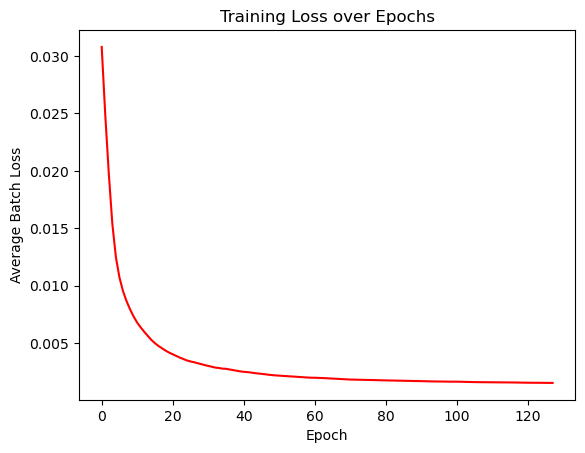

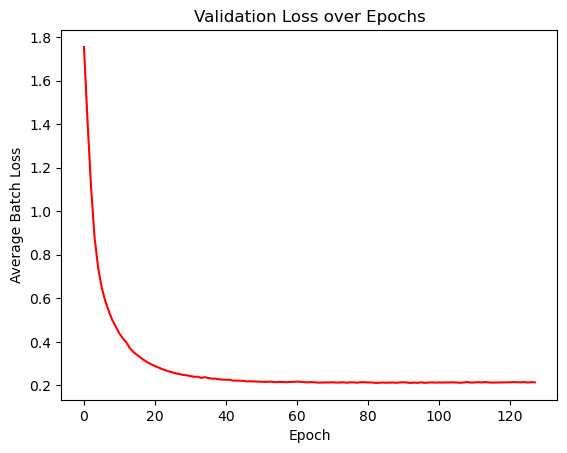

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.053357
Avg batch PSNR: 18.732241
Avg batch SSIM: 0.821921

TRAINING RECONSRTUCTION MODEL FOR: 2tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.478501
-------------------------------
Epoch 8

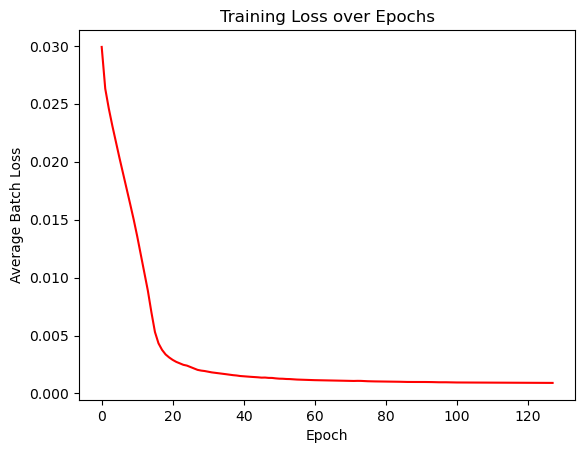

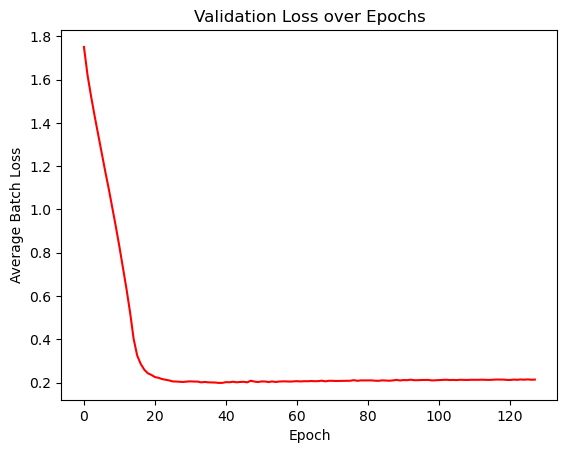

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.053536
Avg batch PSNR: 18.586390
Avg batch SSIM: 0.829149

TRAINING RECONSRTUCTION MODEL FOR: 50tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.438278
-------------------------------
Epoch 

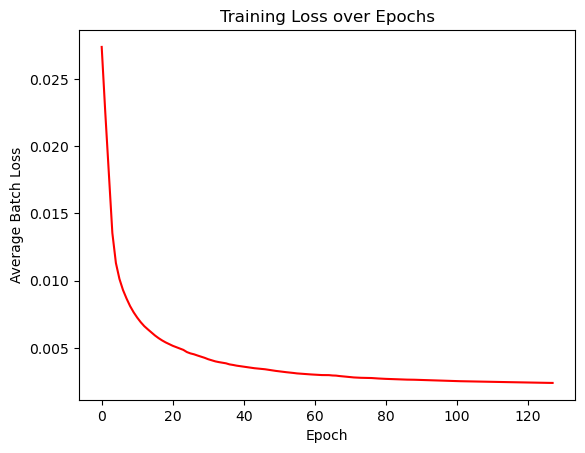

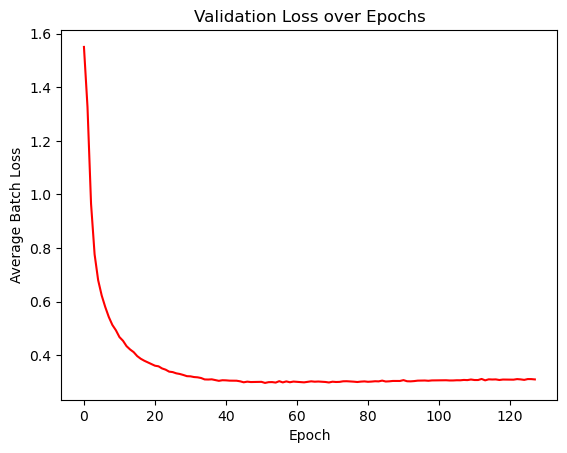

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.077312
Avg batch PSNR: 16.712563
Avg batch SSIM: 0.720949

TRAINING RECONSRTUCTION MODEL FOR: 5tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.553608
-------------------------------
Epoch 8

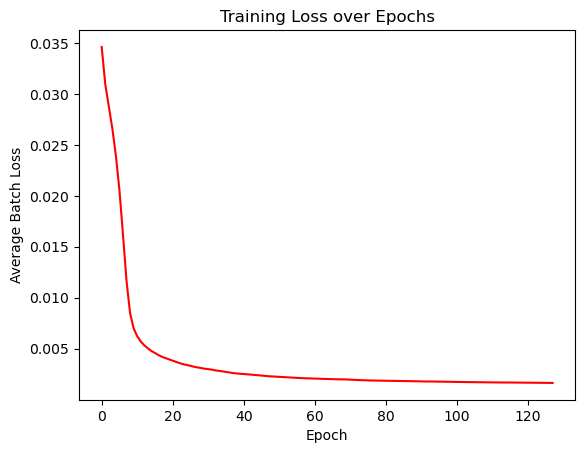

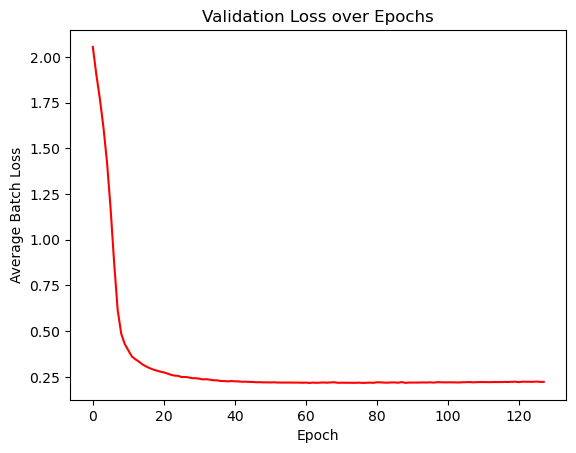

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.055567
Avg batch PSNR: 18.370851
Avg batch SSIM: 0.814148

TRAINING RECONSRTUCTION MODEL FOR: nnfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.469754
-------------------------------
Epoch 8

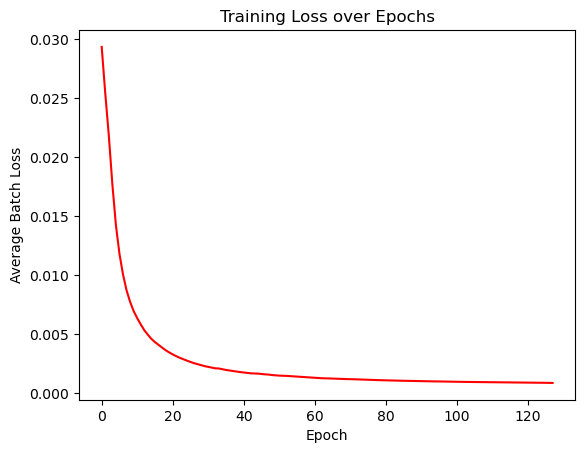

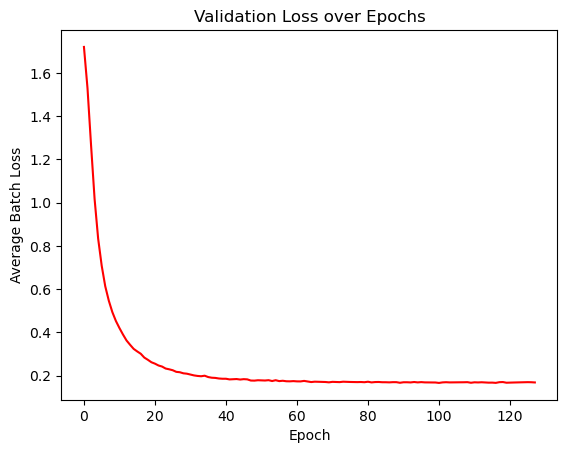

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.042071
Avg batch PSNR: 19.867270
Avg batch SSIM: 0.868832

TRAINING RECONSRTUCTION MODEL FOR: 100n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.471923
-------------------------------
Epoch 8

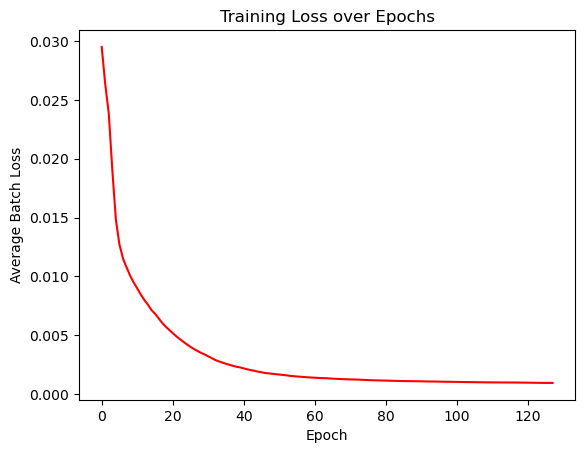

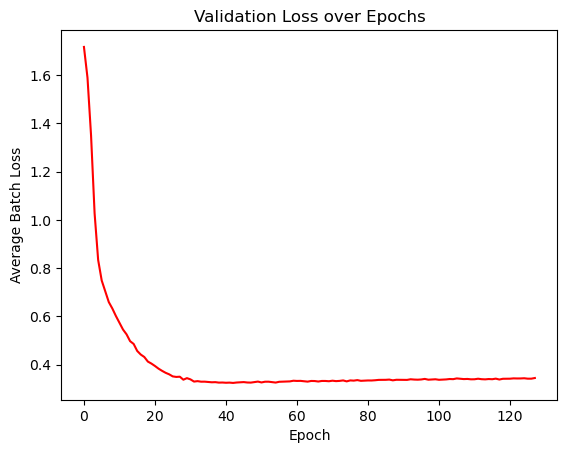

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.086036
Avg batch PSNR: 16.640438
Avg batch SSIM: 0.670186

TRAINING RECONSRTUCTION MODEL FOR: 37n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.487193
-------------------------------
Epoch 8


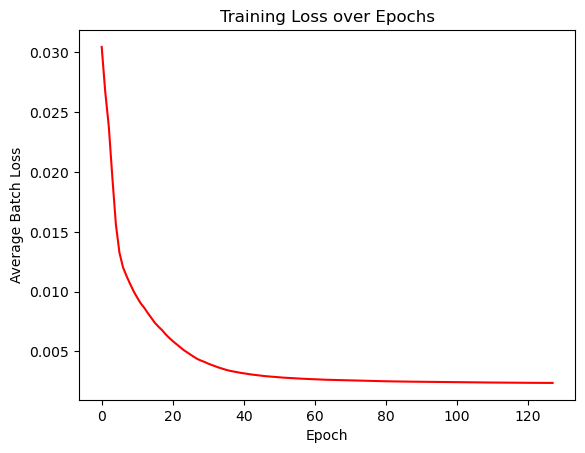

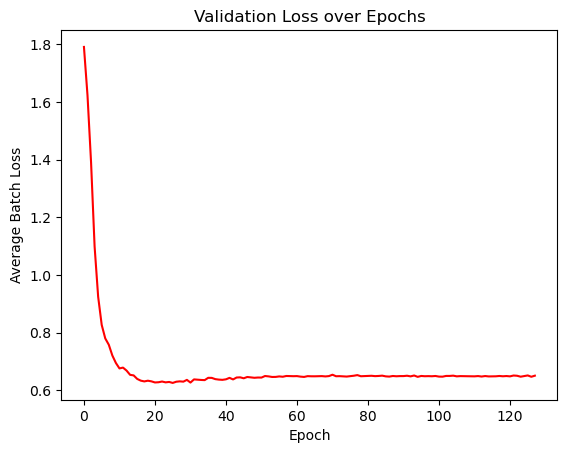

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.162569
Avg batch PSNR: 13.589989
Avg batch SSIM: 0.415507

TRAINING RECONSRTUCTION MODEL FOR: 50n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.480539
-------------------------------
Epoch 8


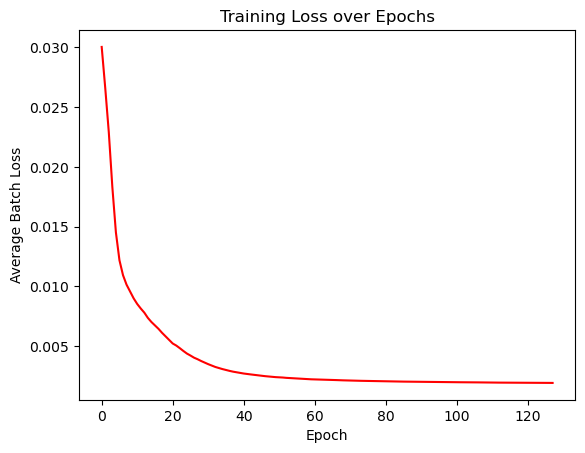

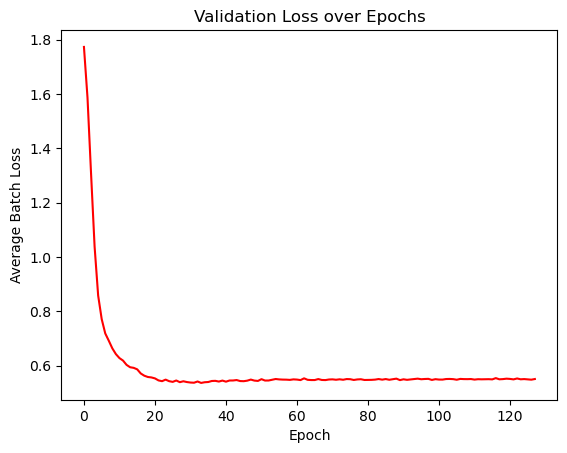

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.137748
Avg batch PSNR: 14.396513
Avg batch SSIM: 0.492491

TRAINING RECONSRTUCTION MODEL FOR: 62n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.461209
-------------------------------
Epoch 8


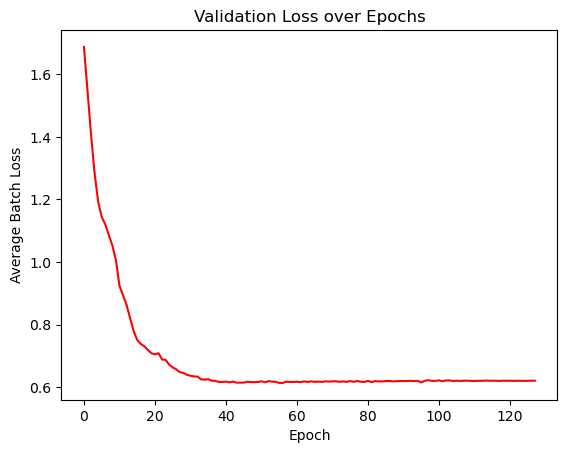

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.155223
Avg batch PSNR: 13.899210
Avg batch SSIM: 0.417008

TRAINING RECONSRTUCTION MODEL FOR: 75n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.470332
-------------------------------
Epoch 8


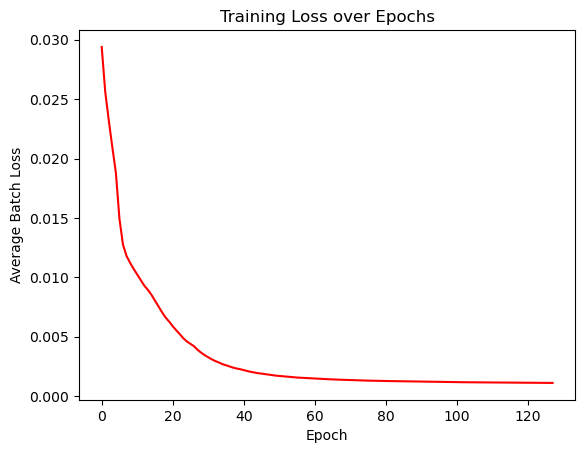

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.120276
Avg batch PSNR: 15.007339
Avg batch SSIM: 0.556233

TRAINING RECONSRTUCTION MODEL FOR: 87p5n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.461575
-------------------------------
Epoch 

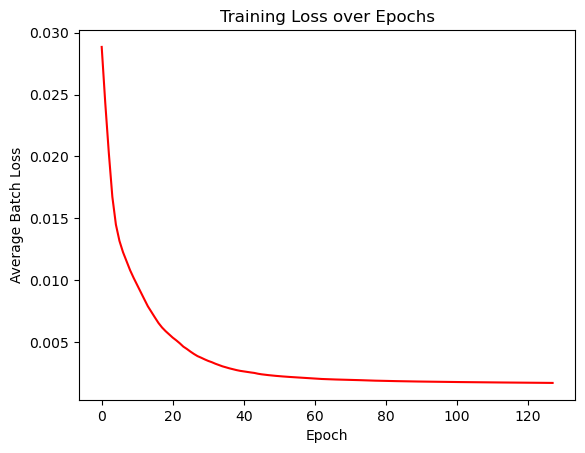

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.131166
Avg batch PSNR: 14.548243
Avg batch SSIM: 0.531060

TRAINING RECONSRTUCTION MODEL FOR: a25n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.478328
-------------------------------
Epoch 8

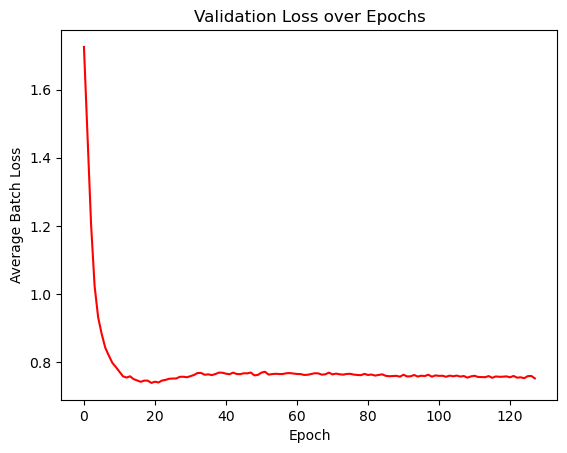

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.188084
Avg batch PSNR: 13.472869
Avg batch SSIM: 0.335410

TRAINING RECONSRTUCTION MODEL FOR: 10fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.441194
-------------------------------
Epoch 8

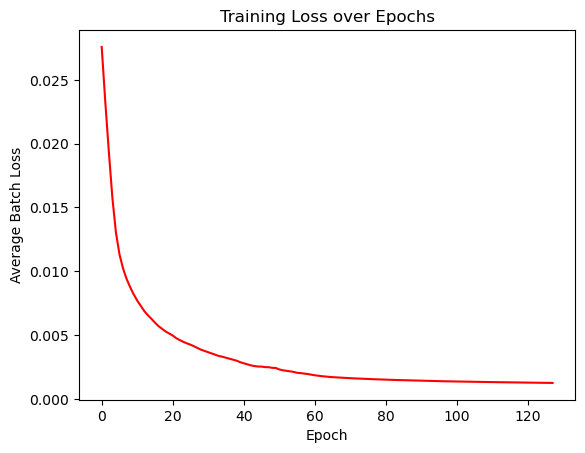

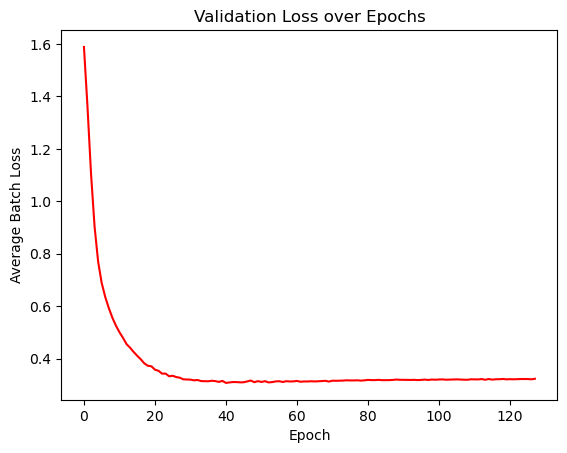

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.080670
Avg batch PSNR: 16.667132
Avg batch SSIM: 0.722327

TRAINING RECONSRTUCTION MODEL FOR: 3fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.507027
-------------------------------
Epoch 8


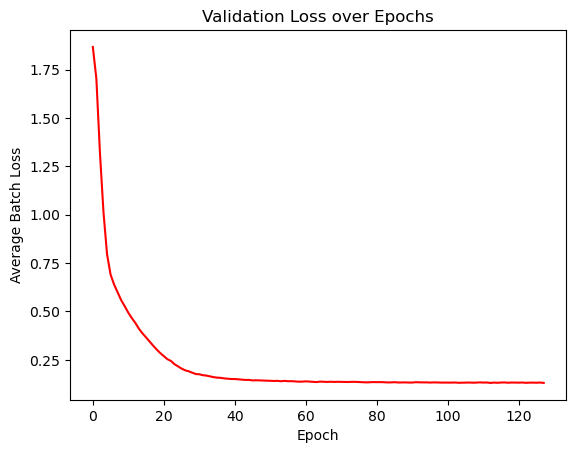

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.032662
Avg batch PSNR: 21.362612
Avg batch SSIM: 0.883071

TRAINING RECONSRTUCTION MODEL FOR: 5fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.414142
-------------------------------
Epoch 8


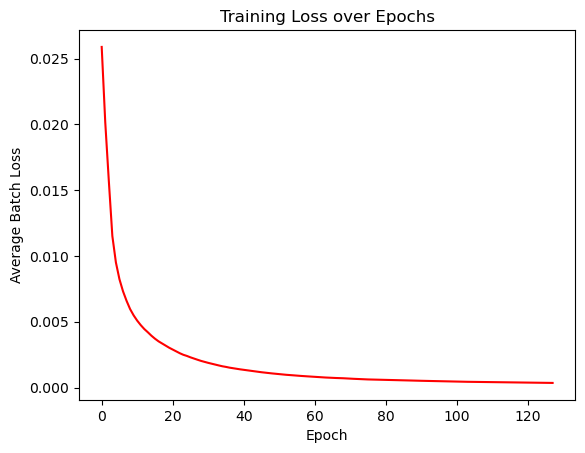

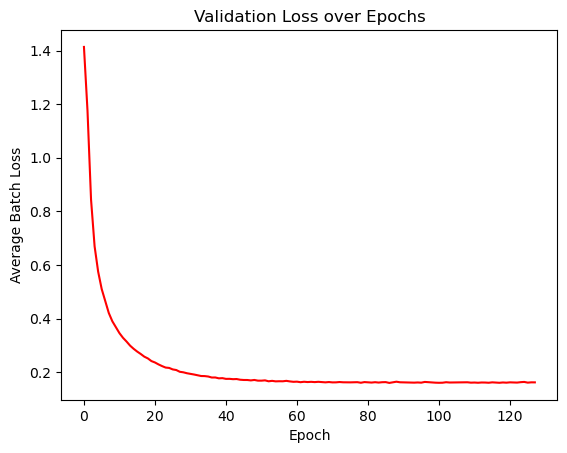

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.040567
Avg batch PSNR: 20.322850
Avg batch SSIM: 0.854944

TRAINING RECONSRTUCTION MODEL FOR: 6fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.503043
-------------------------------
Epoch 8


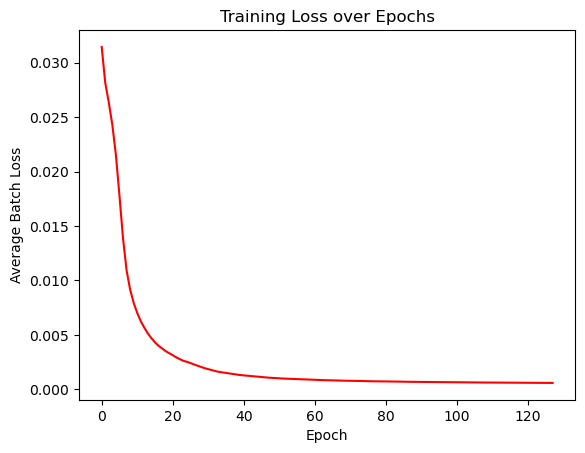

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.058874
Avg batch PSNR: 18.335490
Avg batch SSIM: 0.799773

TRAINING RECONSRTUCTION MODEL FOR: 7a5fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.478075
-------------------------------
Epoch 

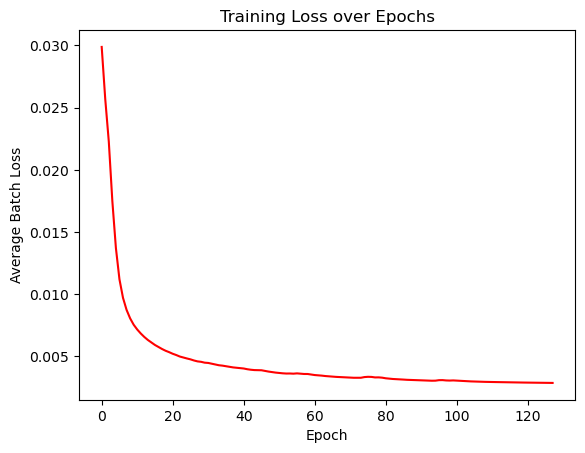

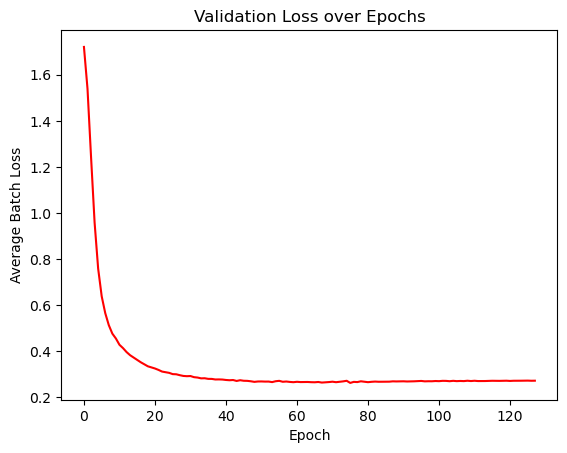

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.067852
Avg batch PSNR: 17.246171
Avg batch SSIM: 0.758492

TRAINING RECONSRTUCTION MODEL FOR: aa15fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.510486
-------------------------------
Epoch

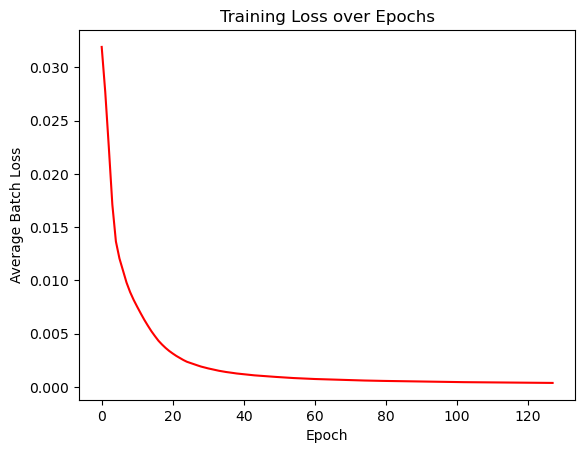

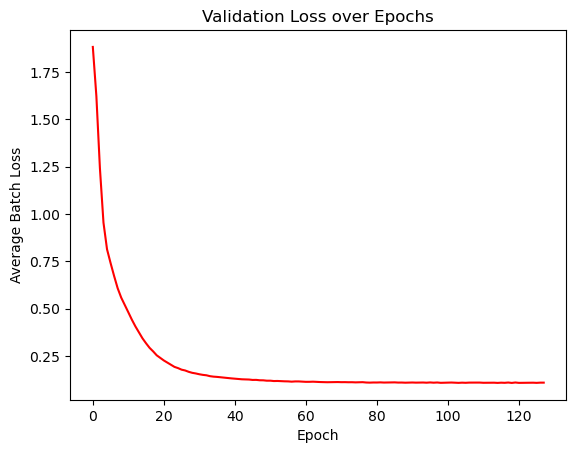

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.027142
Avg batch PSNR: 22.049793
Avg batch SSIM: 0.912829

TRAINING RECONSRTUCTION MODEL FOR: aa20fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.514381
-------------------------------
Epoch

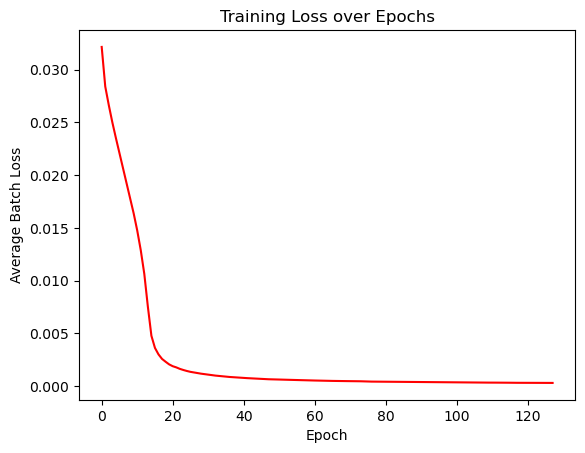

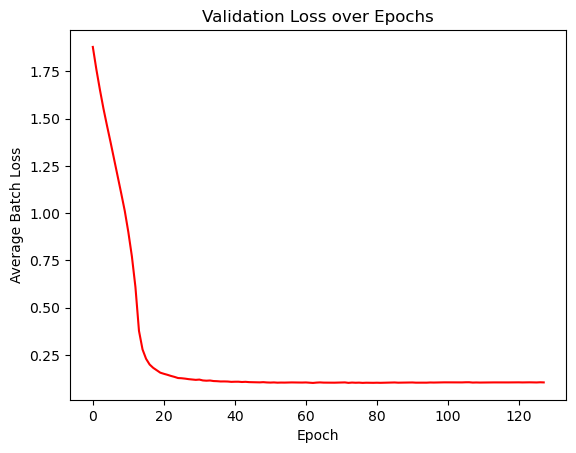

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.025978
Avg batch PSNR: 22.485897
Avg batch SSIM: 0.921261

TRAINING RECONSRTUCTION MODEL FOR: aa25fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.509768
-------------------------------
Epoch

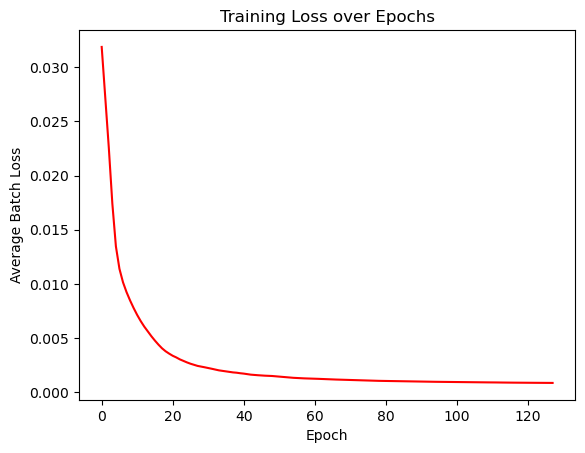

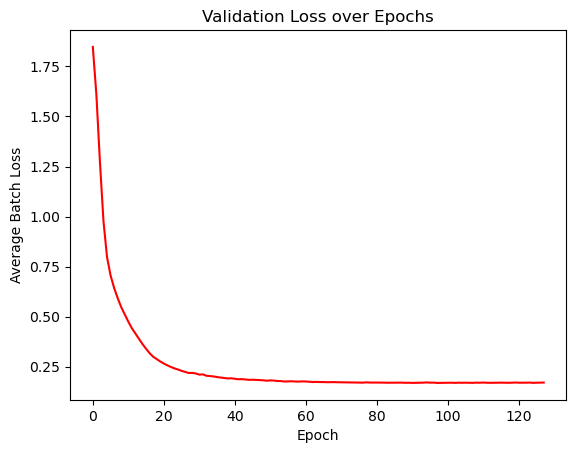

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.042788
Avg batch PSNR: 20.042949
Avg batch SSIM: 0.859391

TRAINING RECONSRTUCTION MODEL FOR: aa30fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.481572
-------------------------------
Epoch

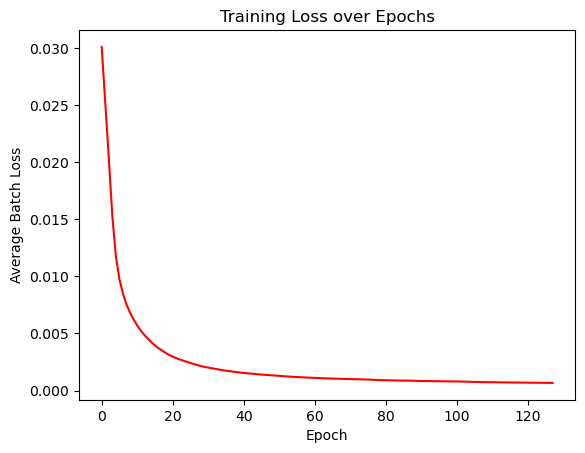

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.025651
Avg batch PSNR: 22.064546
Avg batch SSIM: 0.916456

TRAINING RECONSRTUCTION MODEL FOR: aa35fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.503216
-------------------------------
Epoch

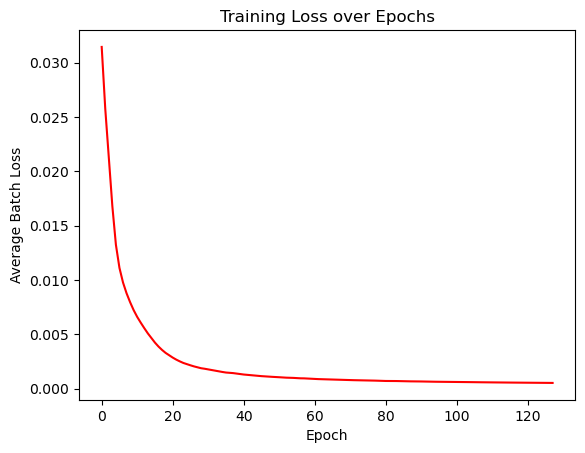

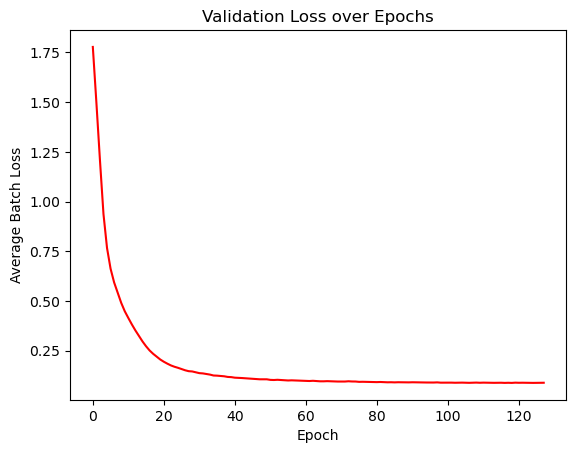

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.022044
Avg batch PSNR: 23.091159
Avg batch SSIM: 0.929107

TRAINING RECONSRTUCTION MODEL FOR: aa40fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.531486
-------------------------------
Epoch

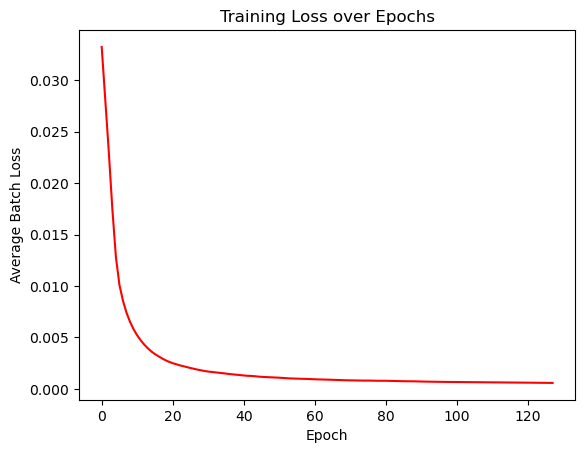

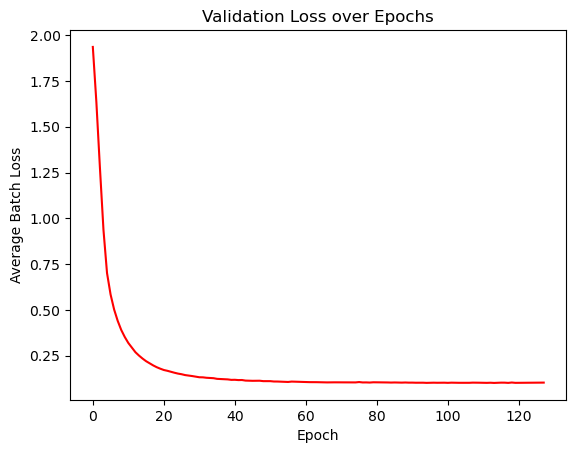

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.025873
Avg batch PSNR: 22.222122
Avg batch SSIM: 0.914045

TRAINING RECONSRTUCTION MODEL FOR: aa5fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.517877
-------------------------------
Epoch 

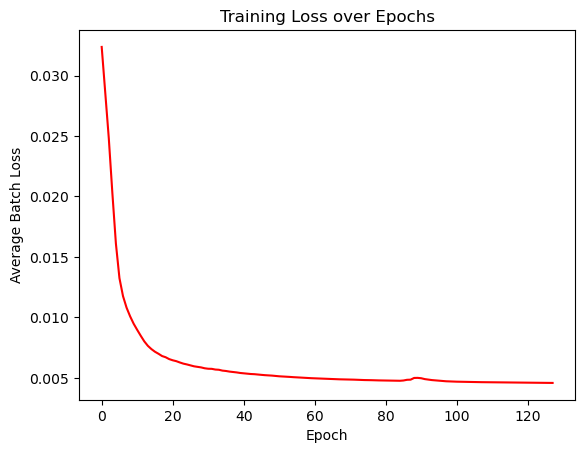

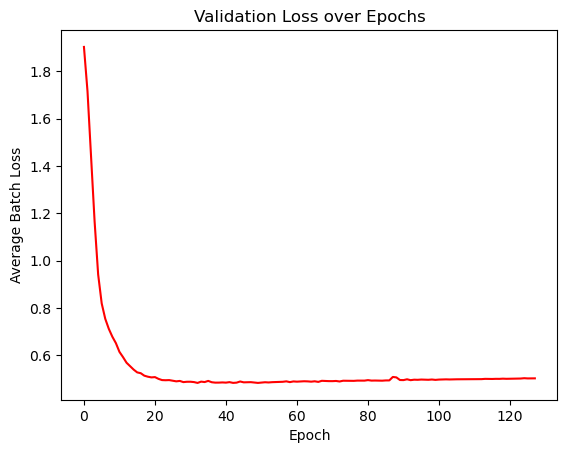

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.125595
Avg batch PSNR: 14.793571
Avg batch SSIM: 0.572544

TRAINING RECONSRTUCTION MODEL FOR: aa6fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.479833
-------------------------------
Epoch 

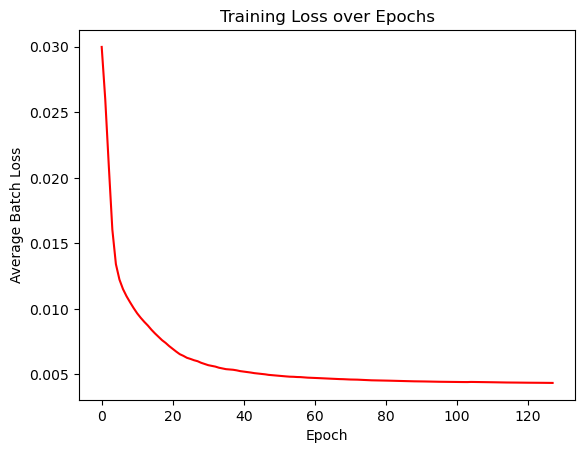

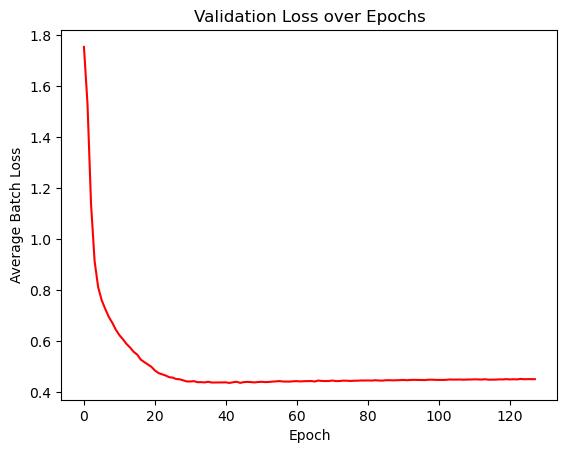

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.112597
Avg batch PSNR: 15.087665
Avg batch SSIM: 0.592428


In [5]:
# hyper parameters
batch_size = 50
val_size = 0.2
epochs = 128
learning_rate = 1e-3
loss_fn = L1_SSIM_loss(window_size=2, n_channels=1).to(device)

num_features = 100

###############################################################################
# IMAGE RECONSTRUCTION
###############################################################################

# VARIED NOISE LEVELS
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/ASE_noise/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/ASE_noise/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = f'../data/features/ASE_noise/{num_features}_reconstruction_results.csv'
results.to_csv(filename, index=False)


# VARIED INTEGRATION TIMES
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/integration_time/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/integration_time/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = f'../data/features/integration_time/{num_features}_reconstruction_results.csv'
results.to_csv(filename, index=False)

In [ ]:
# hyper parameters
batch_size = 50
val_size = 0.2
epochs = 128
learning_rate = 1e-3
loss_fn = L1_SSIM_loss(window_size=2, n_channels=1).to(device)

num_features = 50

###############################################################################
# IMAGE RECONSTRUCTION
###############################################################################

# VARIED NOISE LEVELS
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/ASE_noise/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/ASE_noise/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = f'../data/features/ASE_noise/{num_features}_reconstruction_results.csv'
results.to_csv(filename, index=False)


# VARIED INTEGRATION TIMES
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/integration_time/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/integration_time/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = f'../data/features/integration_time/{num_features}_reconstruction_results.csv'
results.to_csv(filename, index=False)


TRAINING RECONSRTUCTION MODEL FOR: annd40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=50, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.446475
-------------------------------
Epoch 8
Avg batch loss: 0.202254
-------------------------------
Epoch 16
Avg batch l

In [ ]:
# hyper parameters
batch_size = 50
val_size = 0.2
epochs = 128
learning_rate = 1e-3
loss_fn = L1_SSIM_loss(window_size=2, n_channels=1).to(device)

num_features = 25

###############################################################################
# IMAGE RECONSTRUCTION
###############################################################################

# VARIED NOISE LEVELS
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/ASE_noise/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/ASE_noise/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = f'../data/features/ASE_noise/{num_features}_reconstruction_results.csv'
results.to_csv(filename, index=False)


# VARIED INTEGRATION TIMES
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/integration_time/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/integration_time/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = f'../data/features/integration_time/{num_features}_reconstruction_results.csv'
results.to_csv(filename, index=False)

In [ ]:
# hyper parameters
batch_size = 50
val_size = 0.2
epochs = 128
learning_rate = 1e-3
loss_fn = L1_SSIM_loss(window_size=2, n_channels=1).to(device)

num_features = 10

###############################################################################
# IMAGE RECONSTRUCTION
###############################################################################

# VARIED NOISE LEVELS
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/ASE_noise/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/ASE_noise/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = f'../data/features/ASE_noise/{num_features}_reconstruction_results.csv'
results.to_csv(filename, index=False)


# VARIED INTEGRATION TIMES
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/integration_time/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/integration_time/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = f'../data/features/integration_time/{num_features}_reconstruction_results.csv'
results.to_csv(filename, index=False)

In [ ]:
# hyper parameters
batch_size = 50
val_size = 0.2
epochs = 128
learning_rate = 1e-3
loss_fn = L1_SSIM_loss(window_size=2, n_channels=1).to(device)

num_features = 5

###############################################################################
# IMAGE RECONSTRUCTION
###############################################################################

# VARIED NOISE LEVELS
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/ASE_noise/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/ASE_noise/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = f'../data/features/ASE_noise/{num_features}_reconstruction_results.csv'
results.to_csv(filename, index=False)


# VARIED INTEGRATION TIMES
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/integration_time/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/integration_time/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate, num_features)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = f'../data/features/integration_time/{num_features}_reconstruction_results.csv'
results.to_csv(filename, index=False)